<a href="https://colab.research.google.com/github/MemoryLeeks13/FCN_MNIST/blob/main/CSC726Piccione_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=fd02e2bcd332f2fcd43a362ff8e317a5138bf3d320b11a97bb354563a9a206e1
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy as idx
from sklearn.model_selection import train_test_split
from scipy.special import softmax


# Dataset
# All the code from here down to training split I borrowed from our repo
TRAIN_IMAGE_FILENAME = "/content/MNIST/train-images.idx3-ubyte"
TRAIN_LABEL_FILENAME = "/content/MNIST/train-labels.idx1-ubyte"
TEST_IMAGE_FILENAME = "/content/MNIST/t10k-images.idx3-ubyte"
TEST_LABEL_FILENAME = "/content/MNIST/t10k-labels.idx1-ubyte"

def read_mnist():
  train_images = idx.convert_from_file(TRAIN_IMAGE_FILENAME)
  train_labels = idx.convert_from_file(TRAIN_LABEL_FILENAME)
  test_images = idx.convert_from_file(TEST_IMAGE_FILENAME)
  test_labels = idx.convert_from_file(TEST_LABEL_FILENAME)

  # Standardize the data
  x_train = train_images.reshape(60000, 784)
  mean = np.mean(x_train)
  stddev = np.std(x_train)
  x_train = (x_train - mean) / stddev

  x_test = test_images.reshape(10000, 784)
  x_test = (x_test - mean) / stddev

  # One-hot encoded output
  y_train = np.zeros((60000, 10))
  y_test = np.zeros((10000, 10))
  for i, y in enumerate(train_labels):
    y_train[i][y] = 1
  for i, y, in enumerate(test_labels):
    y_test[i][y] = 1

  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = read_mnist()
# index_list = list(range(len(x_train)))

# Split validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [ ]:
class Neural_Network:
    def __init__(self, input_size: int, hidden_size: int, hidden_layers: int, output_size: int, activation: str="relu", weight_init: str="random"):
        self.hidden_layers = hidden_layers
        self.activation = activation

        # Weight Initialization
        # Glorot(Xavier) is best for 'tanh' and 'sigmoid'
        # He is best for 'relu'
        # default is random
        if weight_init == "xavier":
            self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
            self.w2 = np.random.randn(hidden_size, output_size if hidden_layers == 1 else hidden_size) * np.sqrt(1 / hidden_size)
            if hidden_layers > 1:
                self.w3 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
        elif weight_init == "he":
            self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
            self.w2 = np.random.randn(hidden_size, output_size if hidden_layers == 1 else hidden_size) * np.sqrt(2 / hidden_size)
            if hidden_layers > 1:
                self.w3 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        else:
            self.w1 = np.random.randn(input_size, hidden_size)
            self.w2 = np.random.randn(hidden_size, output_size if hidden_layers == 1 else hidden_size)
            if hidden_layers > 1:
                self.w3 = np.random.randn(hidden_size, output_size)

        # Bias Initialization
        # best practice is to start with all 0s
        self.b1 = np.zeros(hidden_size)
        self.b2 = np.zeros(output_size if hidden_layers == 1 else hidden_size)
        if hidden_layers > 1:
            self.b3 = np.zeros(output_size)

    # Initialize all of the Activation Functions
    def sigmoid(self, x: float):
        return 1/(1 + np.exp(-x))

    def sigmoid_derivative(self, x: float):
        return x * (1-x)

    def tanh(self, x: float):
        return np.tanh(x)

    def tanh_derivative(self, x: float):
        return np.clip(1 - np.power(x, 2), 1e-6, 1)

    def relu(self, x: float):
        return np.maximum(0, x)

    def relu_derivative(self, x: float):
        return (x > 0).astype(float)

    # Create forward prop
    def forward_prop(self, inputs: float, activation: str="relu"):

      if self.activation == "sigmoid":
            self.hidden1 = self.sigmoid(np.dot(inputs, self.w1) + self.b1)
            if self.hidden_layers > 1:
                self.hidden2 = self.sigmoid(np.dot(self.hidden1, self.w2) + self.b2)
                output = softmax(np.dot(self.hidden2, self.w3) + self.b3, axis=1)
            else:
                output = softmax(np.dot(self.hidden1, self.w2) + self.b2, axis=1)

      elif self.activation == "tanh":
          self.hidden1 = self.tanh(np.dot(inputs, self.w1) + self.b1)
          if self.hidden_layers > 1:
              self.hidden2 = self.tanh(np.dot(self.hidden1, self.w2) + self.b2)
              output = softmax(np.dot(self.hidden2, self.w3) + self.b3, axis=1)
          else:
              output = softmax(np.dot(self.hidden1, self.w2) + self.b2, axis=1)

      else:  # Default is ReLU
          self.hidden1 = self.relu(np.dot(inputs, self.w1) + self.b1)
          if self.hidden_layers > 1:
              self.hidden2 = self.relu(np.dot(self.hidden1, self.w2) + self.b2)
              output = softmax(np.dot(self.hidden2, self.w3) + self.b3, axis=1)
          else:
              output = softmax(np.dot(self.hidden1, self.w2) + self.b2, axis=1)

      return output

    def categorical_cross_entropy(self, y_true: float, y_pred: float):
        y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
        return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    #===================
    # MY TRAINING LOOP |
    #===================
    def train(self, X, y, X_val, y_val, learning_rate: float=0.01, epochs: int=50, batch_size: int=64):
      loss_history, val_loss_history = [], []
      weight_history_w1, weight_history_w2, weight_history_w3 = [], [], []

      for epoch in range(epochs):
          epoch_losses = []

          for i in range(0, X.shape[0], batch_size):
              X_batch = X[i:i+batch_size]
              y_batch = y[i:i+batch_size]

              # Forward Pass
              # Uses categorical cross-entropy since we're doing multi-class classification
              output = self.forward_prop(X_batch)
              loss = self.categorical_cross_entropy(y_batch, output)
              epoch_losses.append(loss)

              # Backpropagation
              d_output = output - y_batch
              if self.hidden_layers > 1:
                  d_hidden2 = np.dot(d_output, self.w3.T) * self.relu_derivative(self.hidden2)
                  d_hidden1 = np.dot(d_hidden2, self.w2.T) * self.relu_derivative(self.hidden1)

                  # Update weights for 2 hidden layer
                  self.w3 -= learning_rate * np.dot(self.hidden2.T, d_output)
                  self.b3 -= learning_rate * np.sum(d_output, axis=0)

                  self.w2 -= learning_rate * np.dot(self.hidden1.T, d_hidden2)
                  self.b2 -= learning_rate * np.sum(d_hidden2, axis=0)

                  self.w1 -= learning_rate * np.dot(X_batch.T, d_hidden1)
                  self.b1 -= learning_rate * np.sum(d_hidden1, axis=0)

              else:
                  d_hidden1 = np.dot(d_output, self.w2.T) * self.relu_derivative(self.hidden1)

                  # Update weights for 1 hidden layer
                  self.w2 -= learning_rate * np.dot(self.hidden1.T, d_output)
                  self.b2 -= learning_rate * np.sum(d_output, axis=0)

                  self.w1 -= learning_rate * np.dot(X_batch.T, d_hidden1)
                  self.b1 -= learning_rate * np.sum(d_hidden1, axis=0)

          # Compute average training loss per epoch
          avg_epoch_loss = np.mean(epoch_losses)
          loss_history.append(avg_epoch_loss)

          # Compute validation loss per epoch
          val_output = self.forward_prop(X_val)
          val_loss = self.categorical_cross_entropy(y_val, val_output)
          val_loss_history.append(val_loss)

          # Track weight updates
          weight_history_w1.append(np.linalg.norm(self.w1))
          weight_history_w2.append(np.linalg.norm(self.w2))
          if self.hidden_layers > 1:
            weight_history_w3.append(np.linalg.norm(self.w3))


          # Print loss every 10 epochs so we can see what's going on while training
          if epoch % 10 == 0:
            if self.hidden_layers > 1:
              print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
              print(f"W1 {np.mean(weight_history_w1):.2f}, W2 {np.mean(weight_history_w2):.2f}, W3 {np.mean(weight_history_w3):.2f}")
            else:
              print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
              print(f"W1 {np.mean(weight_history_w1):.2f}, W2 {np.mean(weight_history_w2):.2f}")



      # Evaluate the test accuracy
      test_accuracy = self.evaluate(x_test, y_test)
      print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


      # Plotting the Loss
      # I chose red and blue as the colors because I was reading that those
      # are the standard colors the industry uses which takes into account
      # anyone with color blindness
      plt.figure(figsize=(8, 5))
      plt.plot(range(epochs), loss_history, label="Train Loss", color="red")
      plt.plot(range(epochs), val_loss_history, label="Validation Loss", color="blue", linestyle="--")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.title(f"Training and Validation Loss Over Epochs\nActivation: {self.activation.upper()} | Batch Size: {batch_size} | Learning Rate: {learning_rate}")
      plt.grid(True)
      plt.show()

      # Plot the weight Trajectory
      plt.figure(figsize=(8, 5))
      plt.plot(range(epochs), weight_history_w1, label="W1", color="green")
      plt.plot(range(epochs), weight_history_w2, label="W2", color="purple")
      if self.hidden_layers > 1:
        plt.plot(range(epochs), weight_history_w3, label="W3", color="orange")
      plt.xlabel("Epochs")
      plt.ylabel("Weight Magnitude")
      plt.legend()
      plt.title(f"Weight Trajectory Over Epochs\nActivation: {self.activation.upper()} | Learning Rate: {learning_rate}")
      plt.grid(True)
      plt.show()

    # Calculates the accuracy
    def evaluate(self, X, y):
        predictions = np.argmax(self.forward_prop(X), axis=1)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predictions == true_labels)

TEST1

The first thing I want to test is the training split. I will test the following sizes:
- .20 or 20%
- .25 or 25%
- .30 or 30%
- .33 or 33%

As a baseline, I will use these hyperparameters for this test:
- learning_rate = 0.01
- num of epochs = 50
- batch size = 64
- hidden layers = 1
- num of neurons per layer = 128
- activation function = relu
- weight initialization = He


Epoch 0/50, Train Loss: 0.5190, Val Loss: 0.2544
W1 31.22, W2 23.13
Epoch 10/50, Train Loss: 0.1070, Val Loss: 0.2641
W1 38.60, W2 23.87
Epoch 20/50, Train Loss: 0.0759, Val Loss: 0.3478
W1 44.55, W2 24.54
Epoch 30/50, Train Loss: 0.0816, Val Loss: 0.3331
W1 49.86, W2 25.18
Epoch 40/50, Train Loss: 0.0780, Val Loss: 0.4149
W1 54.93, W2 25.85
Epoch 49/50, Train Loss: 0.0882, Val Loss: 0.4244
W1 59.48, W2 26.47
Test Accuracy: 96.07%


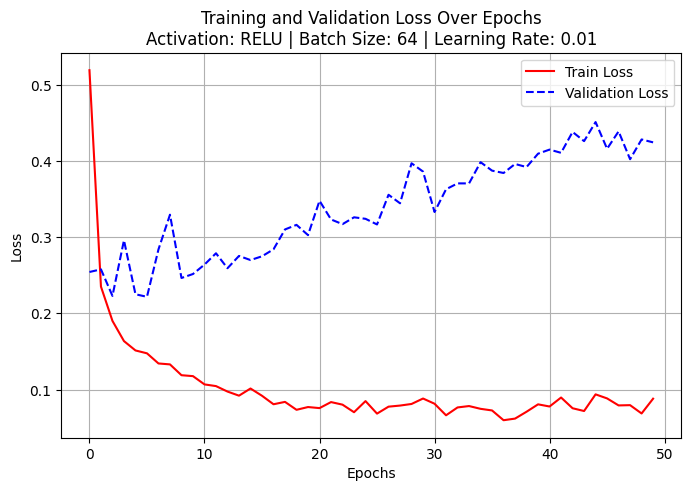

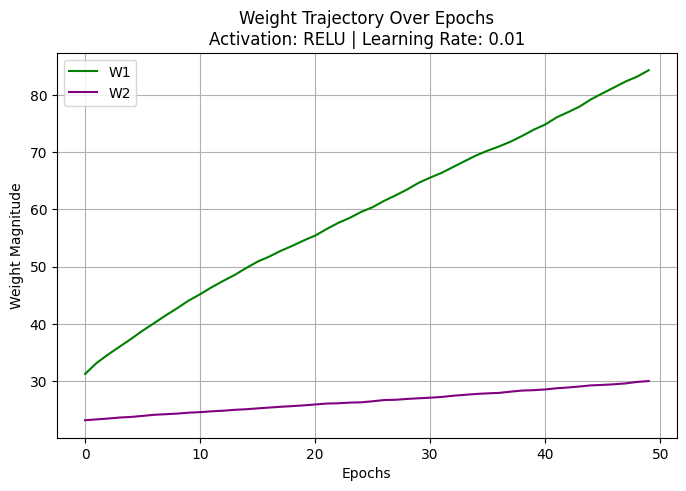

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Above is the result from a training split of 80/20 96.07%

Epoch 0/50, Train Loss: 0.5291, Val Loss: 0.2522
W1 28.58, W2 16.07
Epoch 10/50, Train Loss: 0.1048, Val Loss: 0.3040
W1 35.87, W2 17.00
Epoch 20/50, Train Loss: 0.0793, Val Loss: 0.3276
W1 41.77, W2 17.89
Epoch 30/50, Train Loss: 0.0598, Val Loss: 0.3460
W1 47.03, W2 18.75
Epoch 40/50, Train Loss: 0.0792, Val Loss: 0.4111
W1 51.91, W2 19.54
Epoch 49/50, Train Loss: 0.0513, Val Loss: 0.4194
W1 56.13, W2 20.28
Test Accuracy: 96.10%


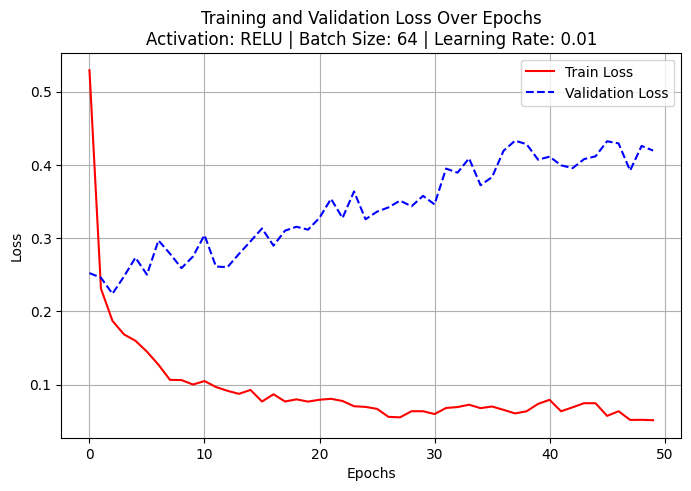

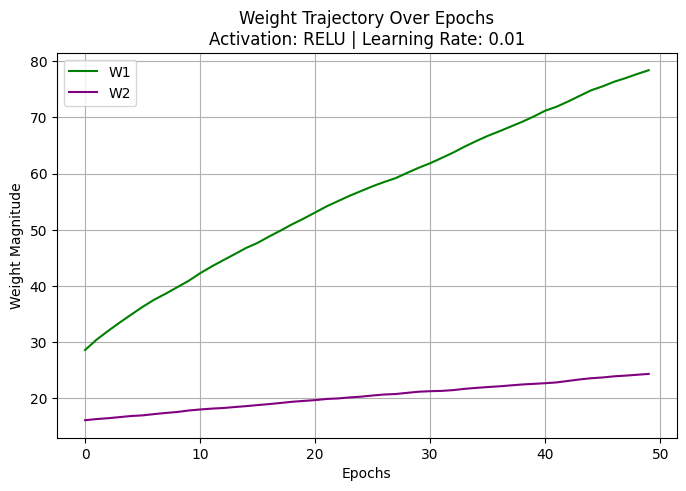

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

TEST2

Above is the result from a training split of 75/25. 96.10%

Epoch 0/50, Train Loss: 0.7312, Val Loss: 0.5673
W1 30.04, W2 13.43
Epoch 10/50, Train Loss: 0.1333, Val Loss: 0.2870
W1 36.53, W2 14.10
Epoch 20/50, Train Loss: 0.0950, Val Loss: 0.3695
W1 41.95, W2 15.01
Epoch 30/50, Train Loss: 0.0778, Val Loss: 0.3819
W1 46.99, W2 15.87
Epoch 40/50, Train Loss: 0.0868, Val Loss: 0.4302
W1 51.55, W2 16.68
Epoch 49/50, Train Loss: 0.0762, Val Loss: 0.4453
W1 55.43, W2 17.39
Test Accuracy: 95.75%


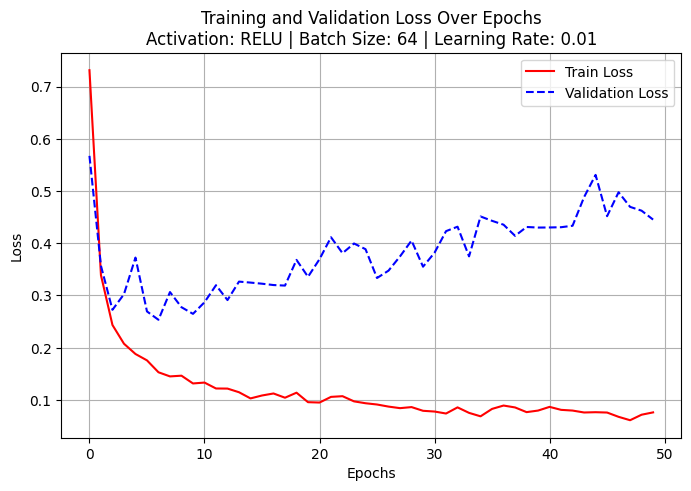

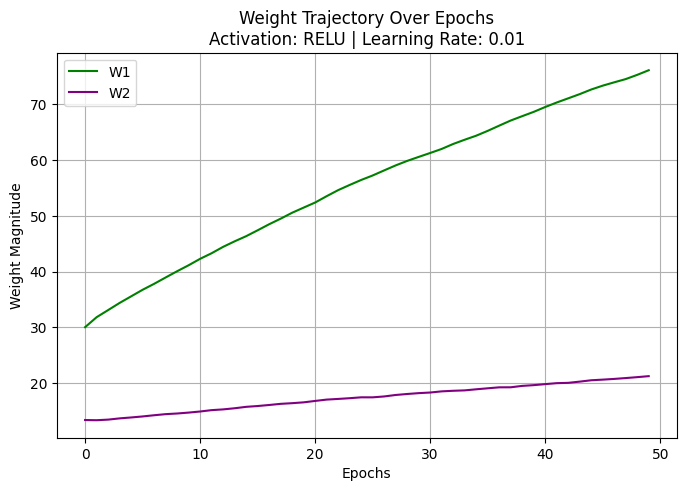

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

TEST3

Above is the result from a training split of 70/30. 95.75%

Epoch 0/50, Train Loss: 0.5949, Val Loss: 0.2776
W1 31.03, W2 29.07
Epoch 10/50, Train Loss: 0.1109, Val Loss: 0.2775
W1 37.13, W2 29.58
Epoch 20/50, Train Loss: 0.0914, Val Loss: 0.3580
W1 42.41, W2 30.06
Epoch 30/50, Train Loss: 0.0726, Val Loss: 0.3744
W1 47.34, W2 30.52
Epoch 40/50, Train Loss: 0.0745, Val Loss: 0.4082
W1 51.90, W2 30.98
Epoch 49/50, Train Loss: 0.0540, Val Loss: 0.4231
W1 55.80, W2 31.41
Test Accuracy: 95.90%


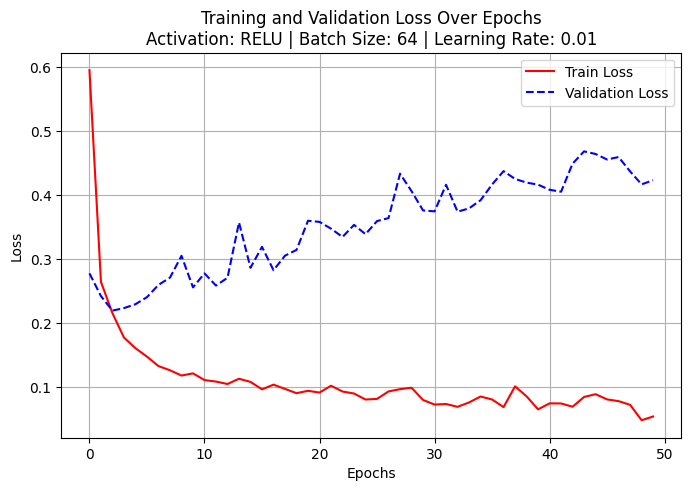

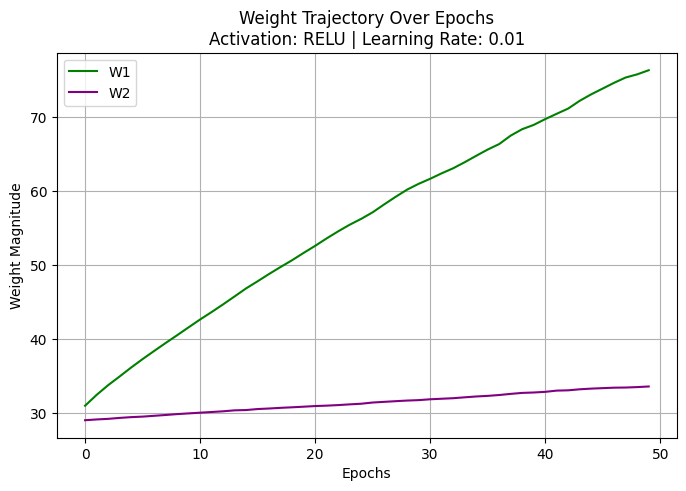

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

TEST4

Above is the result from a training split of 67/33. 95.90% The best performing training split was 75/25. I will use this for the rest of testing, though, out of curiousity I might change it on some tests.

**RELU**

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64



Epoch 0/50, Train Loss: 1.9331, Val Loss: 1.4194
W1 244.82, W2 93.97
Epoch 10/50, Train Loss: 0.6395, Val Loss: 0.6874
W1 245.25, W2 93.93
Epoch 20/50, Train Loss: 0.5135, Val Loss: 0.6510
W1 245.79, W2 93.97
Epoch 30/50, Train Loss: 0.4516, Val Loss: 0.6300
W1 246.25, W2 93.96
Epoch 40/50, Train Loss: 0.4107, Val Loss: 0.6376
W1 246.72, W2 93.97
Epoch 49/50, Train Loss: 0.4121, Val Loss: 0.6471
W1 247.12, W2 93.99
Test Accuracy: 82.97%


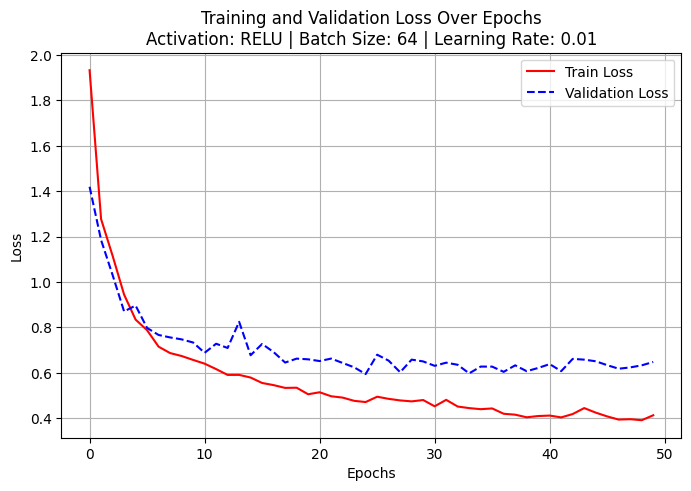

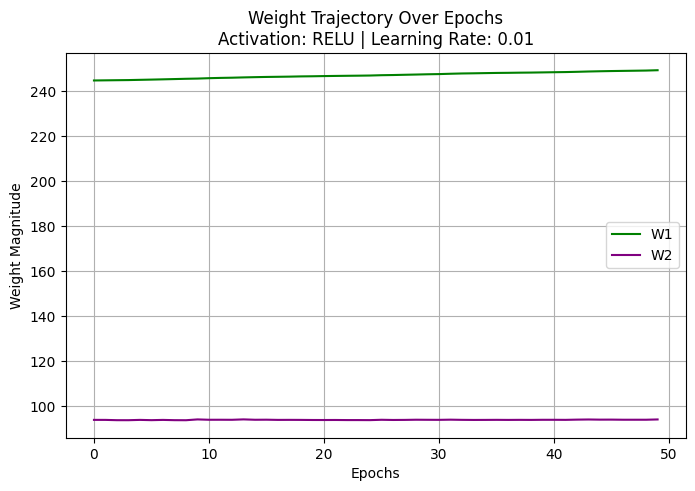

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

TEST5

As we can see in the results above, ReLU and random weight inititialization dont work that great together, but the results arent terrible. The loss and val loss were beginning to grow, which suggests it's beginning to overfit, probably has to also do with the low epochs/neurons.

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/100, Train Loss: 1.8285, Val Loss: 1.3236
W1 234.47, W2 77.53
Epoch 10/100, Train Loss: 0.5805, Val Loss: 0.5982
W1 235.08, W2 77.49
Epoch 20/100, Train Loss: 0.4010, Val Loss: 0.6089
W1 235.61, W2 77.41
Epoch 30/100, Train Loss: 0.3558, Val Loss: 0.6357
W1 236.15, W2 77.38
Epoch 40/100, Train Loss: 0.3764, Val Loss: 0.6400
W1 236.63, W2 77.39
Epoch 50/100, Train Loss: 0.3460, Val Loss: 0.6434
W1 237.07, W2 77.39
Epoch 60/100, Train Loss: 0.3259, Val Loss: 0.6269
W1 237.48, W2 77.41
Epoch 70/100, Train Loss: 0.3228, Val Loss: 0.6380
W1 237.87, W2 77.43
Epoch 80/100, Train Loss: 0.3202, Val Loss: 0.6590
W1 238.27, W2 77.45
Epoch 90/100, Train Loss: 0.3075, Val Loss: 0.6358
W1 238.67, W2 77.47
Epoch 99/100, Train Loss: 0.3284, Val Loss: 0.6776
W1 239.03, W2 77.50
Test Accuracy: 84.70%


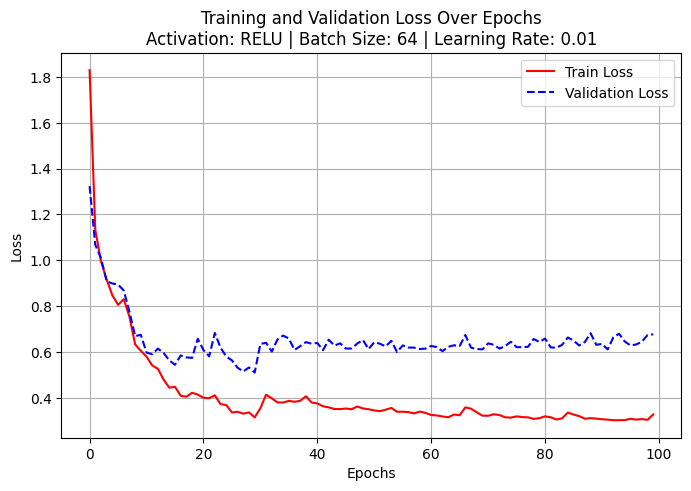

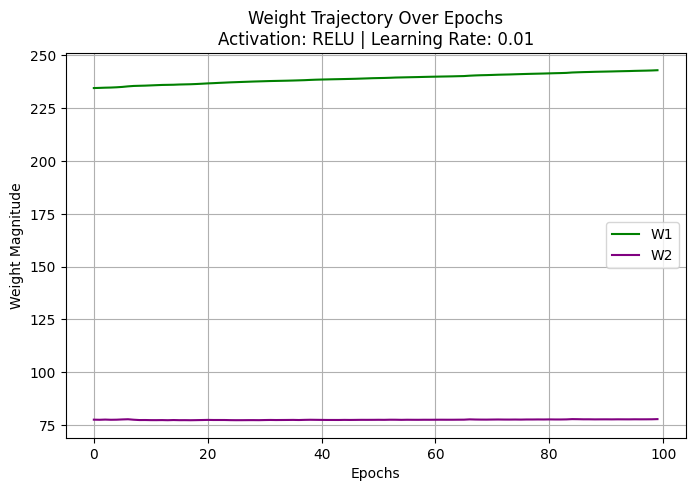

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=64)

TEST6

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 32

Epoch 0/100, Train Loss: 1.4942, Val Loss: 1.0130
W1 225.58, W2 26.12
Epoch 10/100, Train Loss: 0.4161, Val Loss: 1.2357
W1 225.35, W2 25.92
Epoch 20/100, Train Loss: 0.3108, Val Loss: 0.5889
W1 225.40, W2 26.13
Epoch 30/100, Train Loss: 0.2706, Val Loss: 0.6006
W1 225.59, W2 26.39
Epoch 40/100, Train Loss: 0.2396, Val Loss: 0.5532
W1 225.86, W2 26.65
Epoch 50/100, Train Loss: 0.2122, Val Loss: 0.5513
W1 226.18, W2 26.88
Epoch 60/100, Train Loss: 0.1874, Val Loss: 0.5755
W1 226.54, W2 27.10
Epoch 70/100, Train Loss: 0.1802, Val Loss: 0.5665
W1 226.92, W2 27.31
Epoch 80/100, Train Loss: 0.1631, Val Loss: 0.5673
W1 227.30, W2 27.51
Epoch 90/100, Train Loss: 0.1592, Val Loss: 0.5580
W1 227.69, W2 27.70
Epoch 99/100, Train Loss: 0.1454, Val Loss: 0.5909
W1 228.05, W2 27.86
Test Accuracy: 93.17%


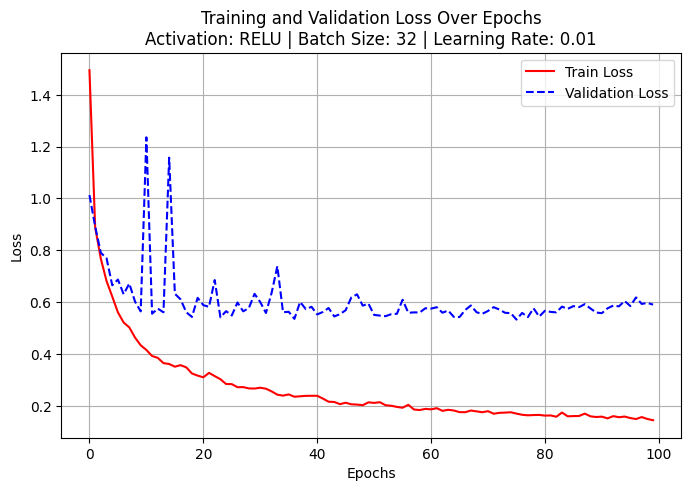

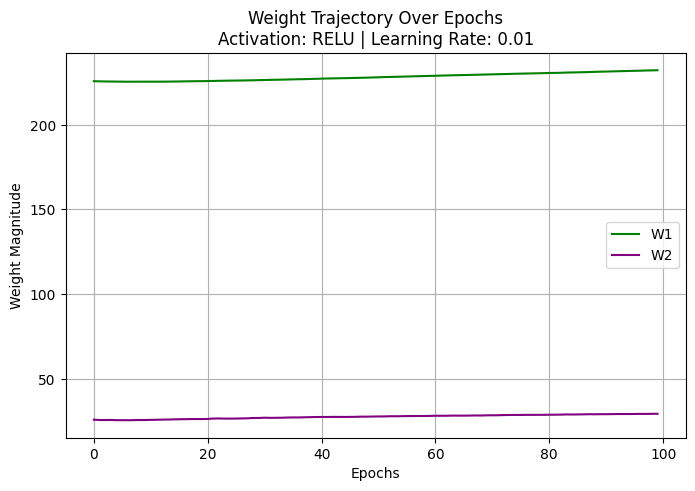

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=32)

As we can see here, changing the epochs and batch size doesnt really help much, and val loss is starting to increase while training loss is continuing to decrease, suggesting overfitting.

TEST7

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.9670, Val Loss: 0.4321
W1 21.72, W2 9.73
Epoch 10/50, Train Loss: 0.2005, Val Loss: 0.3169
W1 29.89, W2 10.53
Epoch 20/50, Train Loss: 0.1576, Val Loss: 0.3464
W1 35.08, W2 11.23
Epoch 30/50, Train Loss: 0.1398, Val Loss: 0.3970
W1 39.69, W2 11.83
Epoch 40/50, Train Loss: 0.1246, Val Loss: 0.4043
W1 43.99, W2 12.42
Epoch 49/50, Train Loss: 0.1364, Val Loss: 0.4953
W1 47.64, W2 12.92
Test Accuracy: 93.96%


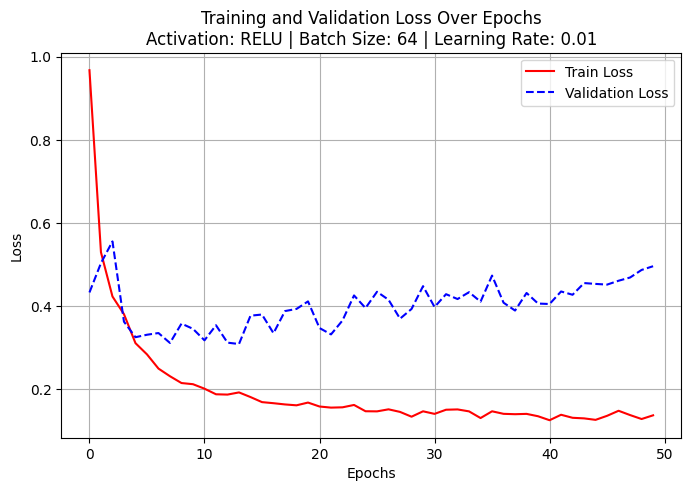

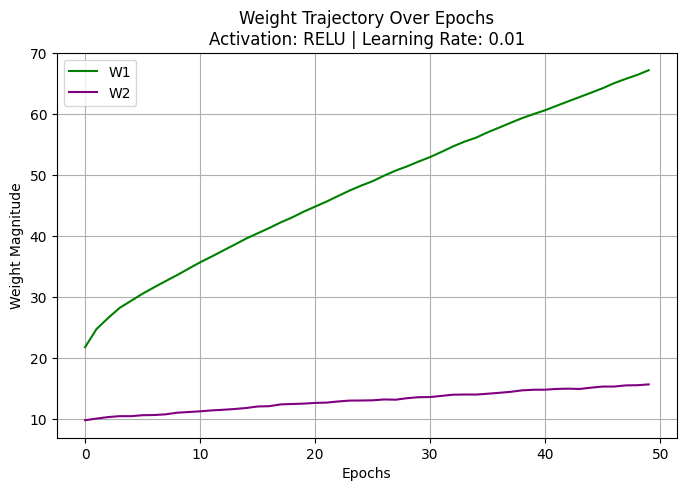

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Taking a look at how ReLU and Xavier weight initialization work together, they work together better than with random. The loss is minimized and we acheived decent accuracy.

There really isnt much reason to continue testing the wrong combo for activation fucntion and weight initializations. So let's use He, which is meant for use with ReLU.

TEST8

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.6373, Val Loss: 0.3383
W1 22.79, W2 8.54
Epoch 10/50, Train Loss: 0.1509, Val Loss: 0.3045
W1 30.67, W2 9.63
Epoch 20/50, Train Loss: 0.1231, Val Loss: 0.3595
W1 36.62, W2 10.56
Epoch 30/50, Train Loss: 0.1237, Val Loss: 0.4266
W1 41.90, W2 11.37
Epoch 40/50, Train Loss: 0.1149, Val Loss: 0.4509
W1 46.83, W2 12.14
Epoch 49/50, Train Loss: 0.1159, Val Loss: 0.5186
W1 51.15, W2 12.85
Test Accuracy: 94.31%


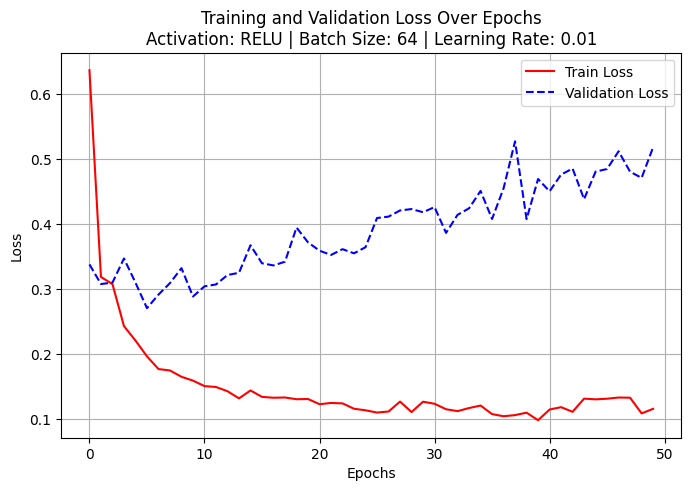

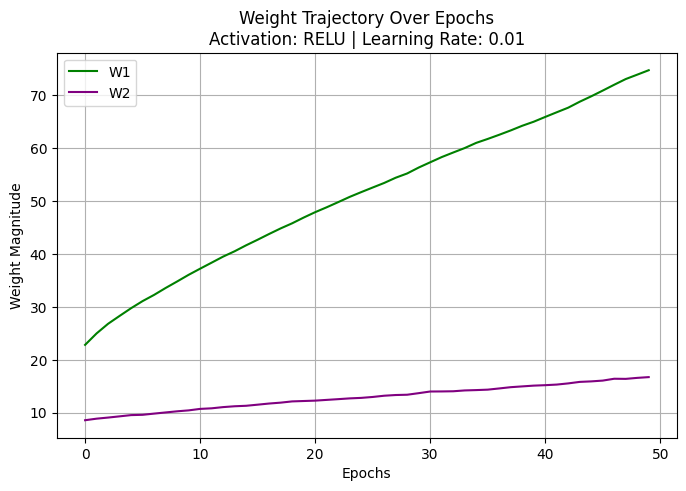

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

These results arent too bad, given only 50 epochs. The loss is decreasing and validation loss is stabilized so it might not be overfitting, and we see increased accuracy already. Lets try increasing the number of neurons and see what happens.

TEST9

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 128
* Batch Size: 64

Epoch 0/50, Train Loss: 0.5969, Val Loss: 0.2850
W1 29.70, W2 18.65
Epoch 10/50, Train Loss: 0.1084, Val Loss: 0.2757
W1 36.47, W2 19.47
Epoch 20/50, Train Loss: 0.0769, Val Loss: 0.2982
W1 42.01, W2 20.27
Epoch 30/50, Train Loss: 0.0728, Val Loss: 0.3703
W1 47.05, W2 21.01
Epoch 40/50, Train Loss: 0.0587, Val Loss: 0.4245
W1 51.75, W2 21.76
Epoch 49/50, Train Loss: 0.0828, Val Loss: 0.4849
W1 55.93, W2 22.44
Test Accuracy: 95.48%


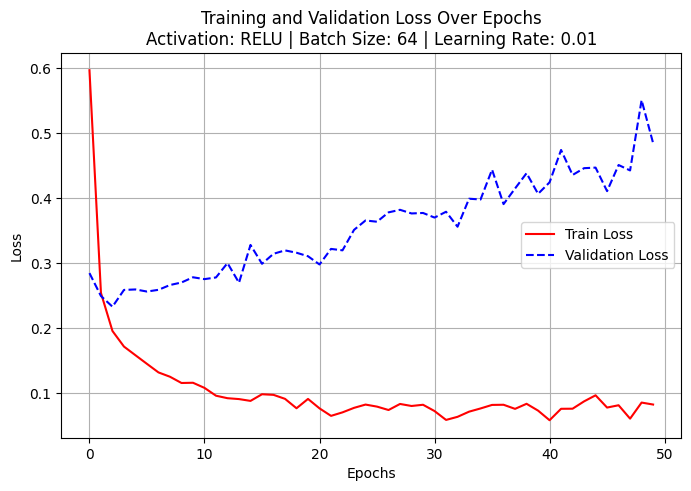

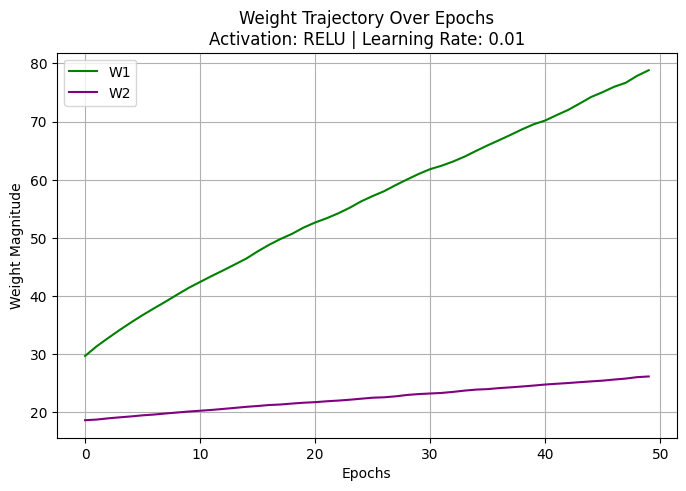

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Adding more neurons did help increase the accuracy, but I think that is not telling the whole story here. It's definitely overfitting. Let's try more epochs.

TEST10

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 128
* Batch Size: 64

Epoch 0/100, Train Loss: 0.5394, Val Loss: 0.2757
W1 26.04, W2 10.93
Epoch 10/100, Train Loss: 0.0979, Val Loss: 0.2729
W1 34.43, W2 12.50
Epoch 20/100, Train Loss: 0.0747, Val Loss: 0.3635
W1 40.99, W2 13.93
Epoch 30/100, Train Loss: 0.0757, Val Loss: 0.3861
W1 46.81, W2 15.20
Epoch 40/100, Train Loss: 0.0929, Val Loss: 0.4879
W1 52.54, W2 16.50
Epoch 50/100, Train Loss: 0.0927, Val Loss: 0.4702
W1 58.29, W2 17.81
Epoch 60/100, Train Loss: 0.0702, Val Loss: 0.5528
W1 63.98, W2 19.11
Epoch 70/100, Train Loss: 0.0991, Val Loss: 0.5821
W1 69.66, W2 20.44
Epoch 80/100, Train Loss: 0.0732, Val Loss: 0.5451
W1 75.38, W2 21.78
Epoch 90/100, Train Loss: 0.0739, Val Loss: 0.5633
W1 81.08, W2 23.13
Epoch 99/100, Train Loss: 0.0827, Val Loss: 0.6353
W1 86.05, W2 24.29
Test Accuracy: 96.04%


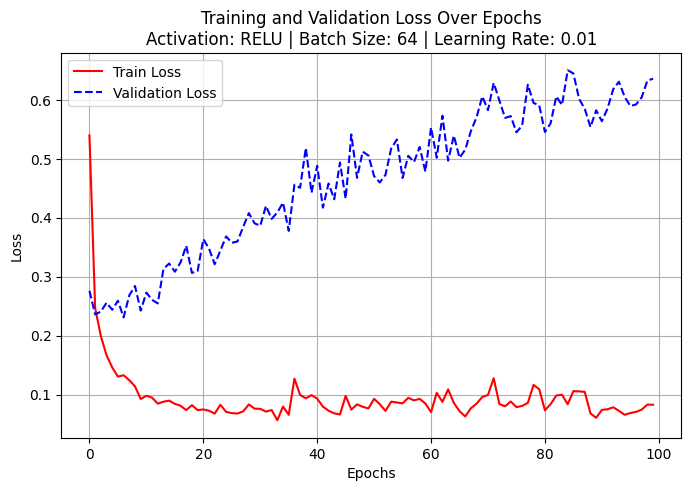

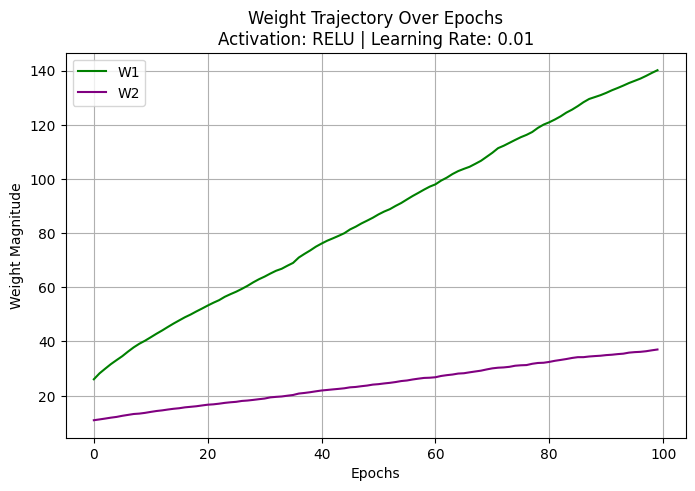

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=64)

This is still overfitting. Maybe I need to lower the amount of neurons, let's try that and see. If not, might need to implement some regularization or even add an additional hidden layer.

TEST11

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/100, Train Loss: 0.8052, Val Loss: 0.5703
W1 24.69, W2 15.74
Epoch 10/100, Train Loss: 0.2174, Val Loss: 0.3376
W1 32.42, W2 16.08
Epoch 20/100, Train Loss: 0.1756, Val Loss: 0.3782
W1 37.75, W2 16.54
Epoch 30/100, Train Loss: 0.1529, Val Loss: 0.4039
W1 42.34, W2 16.96
Epoch 40/100, Train Loss: 0.1364, Val Loss: 0.4148
W1 46.67, W2 17.39
Epoch 50/100, Train Loss: 0.1388, Val Loss: 0.4660
W1 50.74, W2 17.83
Epoch 60/100, Train Loss: 0.1287, Val Loss: 0.4766
W1 54.64, W2 18.26
Epoch 70/100, Train Loss: 0.1185, Val Loss: 0.5135
W1 58.43, W2 18.70
Epoch 80/100, Train Loss: 0.1370, Val Loss: 0.5794
W1 62.13, W2 19.15
Epoch 90/100, Train Loss: 0.1306, Val Loss: 0.5456
W1 65.77, W2 19.60
Epoch 99/100, Train Loss: 0.1313, Val Loss: 0.5731
W1 69.03, W2 20.04
Test Accuracy: 94.30%


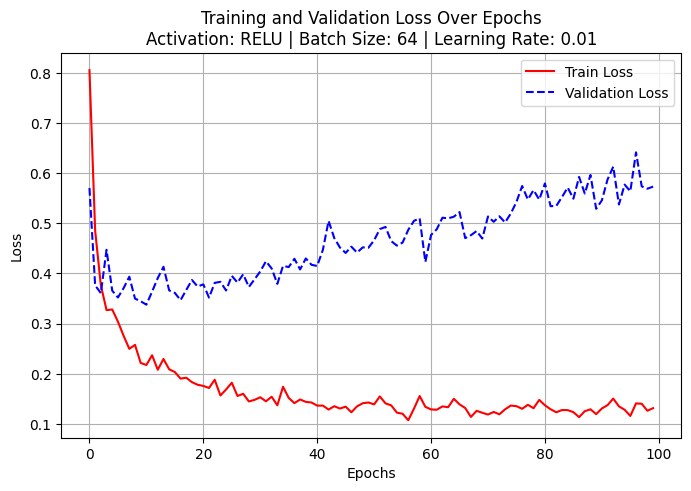

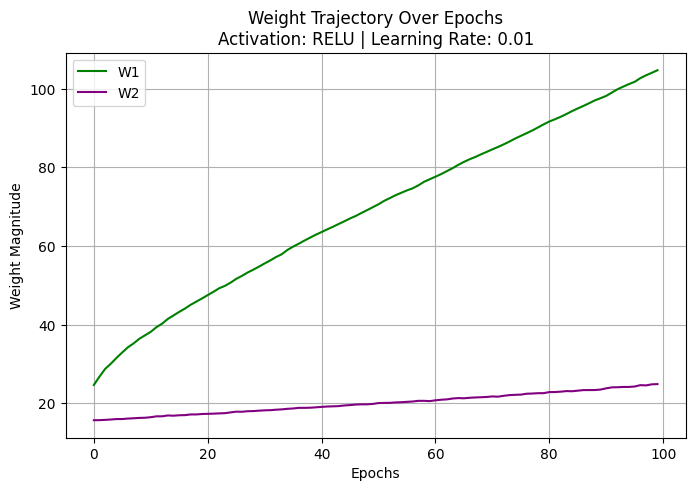

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=64)

That seemed to make things less stable. Let's add another layer and reduce total number of neurons to see what that will do.

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: He
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 1.4760, Val Loss: 1.9283
W1 29.81, W2 29.64
W1 29.81, W2 29.64, W3 17.17
Epoch 10/50, Train Loss: 1.8841, Val Loss: 1.9043
W1 43.34, W2 41.11
W1 43.34, W2 41.11, W3 26.57
Epoch 20/50, Train Loss: 1.8611, Val Loss: 1.8640
W1 51.47, W2 44.06
W1 51.47, W2 44.06, W3 31.11
Epoch 30/50, Train Loss: 1.8390, Val Loss: 1.8339
W1 57.76, W2 45.86
W1 57.76, W2 45.86, W3 32.85
Epoch 40/50, Train Loss: 1.8006, Val Loss: 1.8102
W1 62.97, W2 46.90
W1 62.97, W2 46.90, W3 33.77
Epoch 49/50, Train Loss: 1.7846, Val Loss: 1.8874
W1 66.95, W2 48.39
W1 66.95, W2 48.39, W3 34.41
Test Accuracy: 18.58%


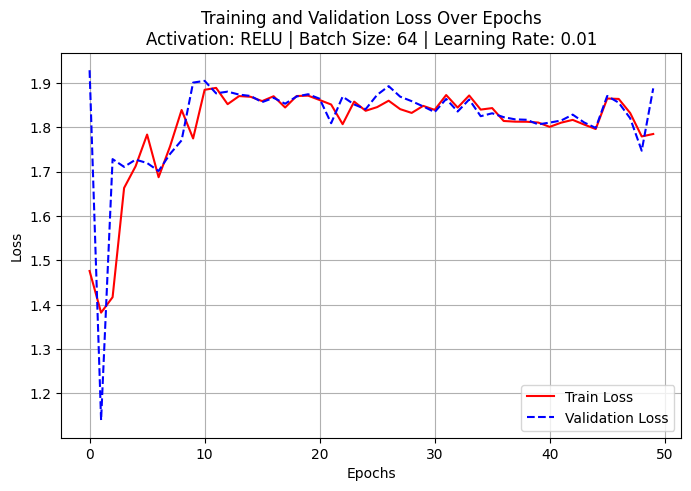

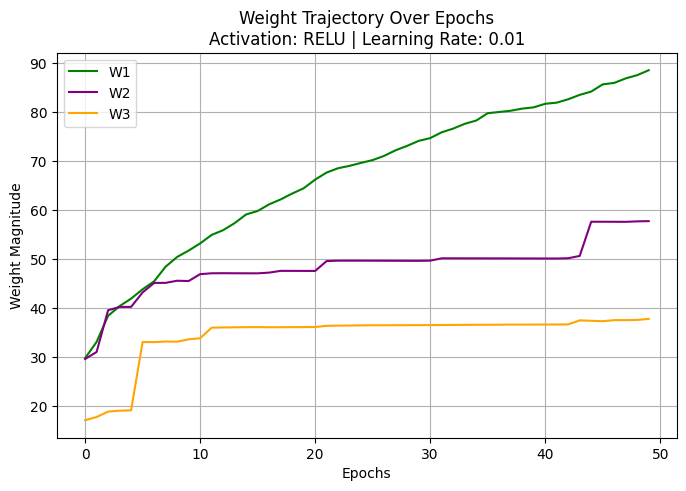

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

These results are very poor. Poor gradient updates might be causing the low accuracy. This seems to be overfitting or maybe adding the second layer wasnt a good idea. Let's adjust some parameters and see.

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 2
* Neurons per Layer: 128
* Batch Size: 64

Epoch 0/100, Train Loss: 2.3459, Val Loss: 2.3028
W1 38.73, W2 30.29
W1 38.73, W2 30.29, W3 17.18
Epoch 10/100, Train Loss: 2.2874, Val Loss: 2.3032
W1 40.10, W2 30.62
W1 40.10, W2 30.62, W3 17.34
Epoch 20/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 43.20, W2 32.34
W1 43.20, W2 32.34, W3 18.97
Epoch 30/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 45.62, W2 33.83
W1 45.62, W2 33.83, W3 20.73
Epoch 40/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 46.86, W2 34.59
W1 46.86, W2 34.59, W3 21.63
Epoch 50/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 47.62, W2 35.05
W1 47.62, W2 35.05, W3 22.17
Epoch 60/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 48.13, W2 35.36
W1 48.13, W2 35.36, W3 22.54
Epoch 70/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 48.49, W2 35.59
W1 48.49, W2 35.59, W3 22.80
Epoch 80/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 48.77, W2 35.76
W1 48.77, W2 35.76, W3 23.00
Epoch 90/100, Train Loss: 2.3034, Val Loss: 2.3032
W1 48.98, W2 35.89
W1 48.98, W2 35.89, W3 23.16
Epoch 99/10

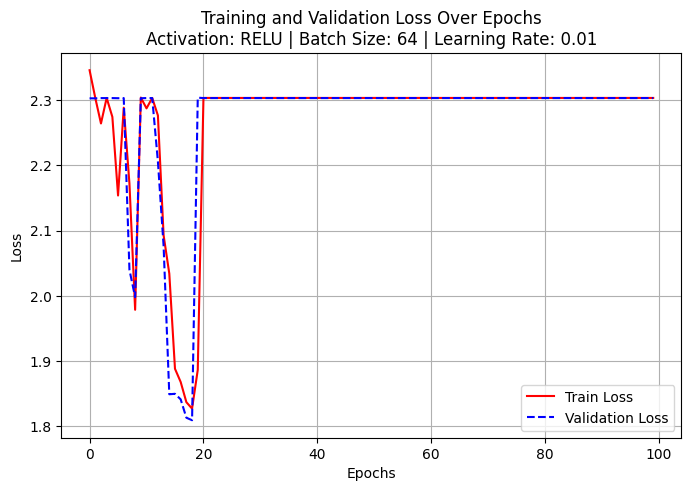

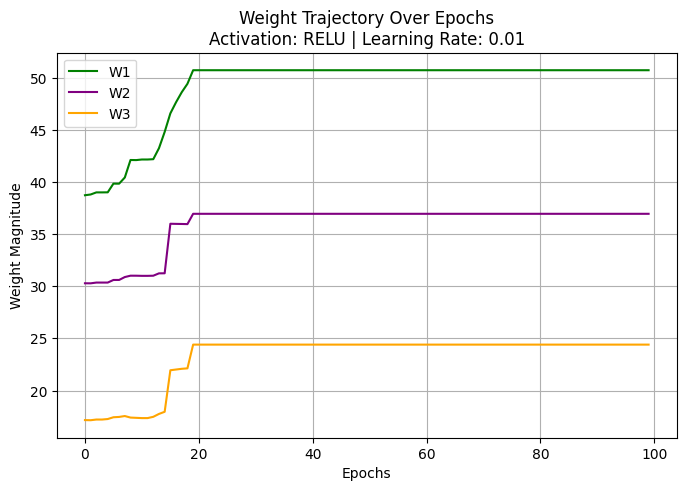

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=64)

So this test was interesting. The loss appears to be stuck, the model is clearly not learning anything, it might as well be guessing at this point. The weight updates were very minor too, could this be due to vanishing gradients?

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.01
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 2
* Neurons per Layer: 32
* Batch Size: 64

Epoch 0/100, Train Loss: 2.0651, Val Loss: 1.8362
W1 62.39, W2 201.23
W1 62.39, W2 201.23, W3 66.67
Epoch 10/100, Train Loss: 2.2005, Val Loss: 2.1998
W1 70.61, W2 202.42
W1 70.61, W2 202.42, W3 66.79
Epoch 20/100, Train Loss: 1.9383, Val Loss: 1.9294
W1 81.26, W2 202.90
W1 81.26, W2 202.90, W3 72.66
Epoch 30/100, Train Loss: 1.9306, Val Loss: 1.9174
W1 88.27, W2 204.27
W1 88.27, W2 204.27, W3 110.34
Epoch 40/100, Train Loss: 1.8552, Val Loss: 1.8479
W1 93.00, W2 204.97
W1 93.00, W2 204.97, W3 129.64
Epoch 50/100, Train Loss: 1.8569, Val Loss: 1.8556
W1 96.33, W2 205.40
W1 96.33, W2 205.40, W3 141.38
Epoch 60/100, Train Loss: 1.8569, Val Loss: 1.8556
W1 98.56, W2 205.68
W1 98.56, W2 205.68, W3 149.26
Epoch 70/100, Train Loss: 1.8569, Val Loss: 1.8556
W1 100.17, W2 205.89
W1 100.17, W2 205.89, W3 154.93
Epoch 80/100, Train Loss: 1.8569, Val Loss: 1.8556
W1 101.38, W2 206.04
W1 101.38, W2 206.04, W3 159.20
Epoch 90/100, Train Loss: 1.8569, Val Loss: 1.8556
W1 102.32, W2 206.16
W1 102.32,

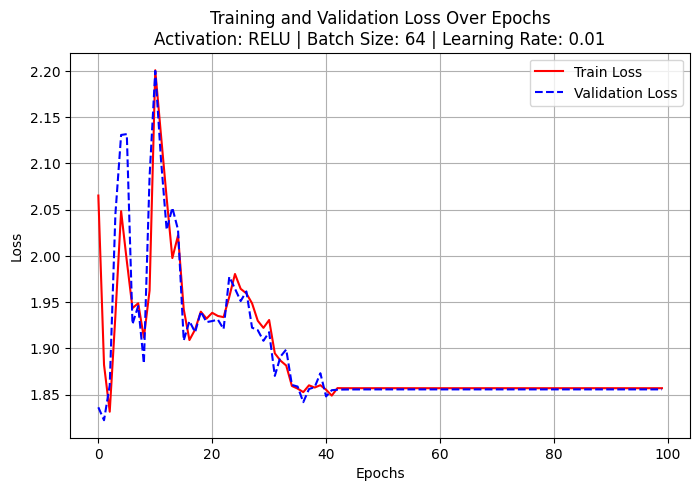

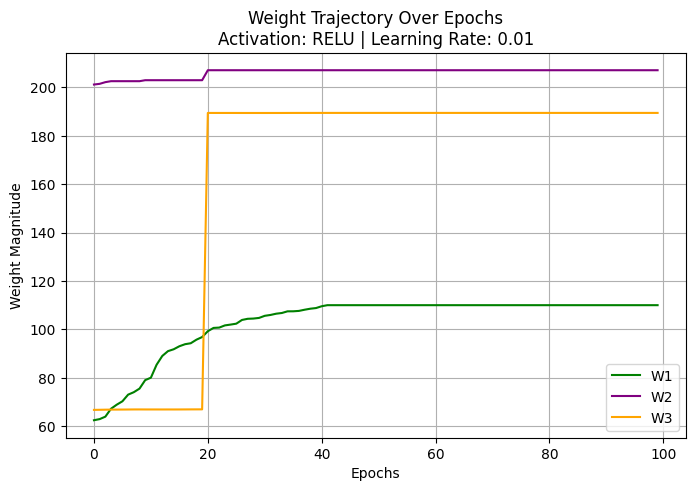

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=32, hidden_layers=2, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=100, batch_size=64)

The model is still not learning effectively. While accuracy did improve, only slightly and certainly not where it should be for this dataset(+90%). Loss plateaus and weights update strangely. There is definitely some instability with these parameters. Im going to try lowering the learning rate and see if that helps some.

This next test will use the following hyperparameters:

* Activation Function: Relu
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/100, Train Loss: 0.3121, Val Loss: 0.1859
W1 11.76, W2 11.34
W1 11.76, W2 11.34, W3 4.88
Epoch 10/100, Train Loss: 0.0200, Val Loss: 0.1036
W1 12.69, W2 11.87
W1 12.69, W2 11.87, W3 5.88
Epoch 20/100, Train Loss: 0.0032, Val Loss: 0.1166
W1 13.21, W2 12.26
W1 13.21, W2 12.26, W3 6.55
Epoch 30/100, Train Loss: 0.0012, Val Loss: 0.1265
W1 13.51, W2 12.51
W1 13.51, W2 12.51, W3 6.97
Epoch 40/100, Train Loss: 0.0007, Val Loss: 0.1332
W1 13.70, W2 12.68
W1 13.70, W2 12.68, W3 7.25
Epoch 50/100, Train Loss: 0.0005, Val Loss: 0.1380
W1 13.84, W2 12.81
W1 13.84, W2 12.81, W3 7.46
Epoch 60/100, Train Loss: 0.0004, Val Loss: 0.1416
W1 13.95, W2 12.90
W1 13.95, W2 12.90, W3 7.62
Epoch 70/100, Train Loss: 0.0003, Val Loss: 0.1446
W1 14.03, W2 12.98
W1 14.03, W2 12.98, W3 7.75
Epoch 80/100, Train Loss: 0.0002, Val Loss: 0.1471
W1 14.10, W2 13.05
W1 14.10, W2 13.05, W3 7.86
Epoch 90/100, Train Loss: 0.0002, Val Loss: 0.1492
W1 14.16, W2 13.10
W1 14.16, W2 13.10, W3 7.95
Epoch 99/100, Train L

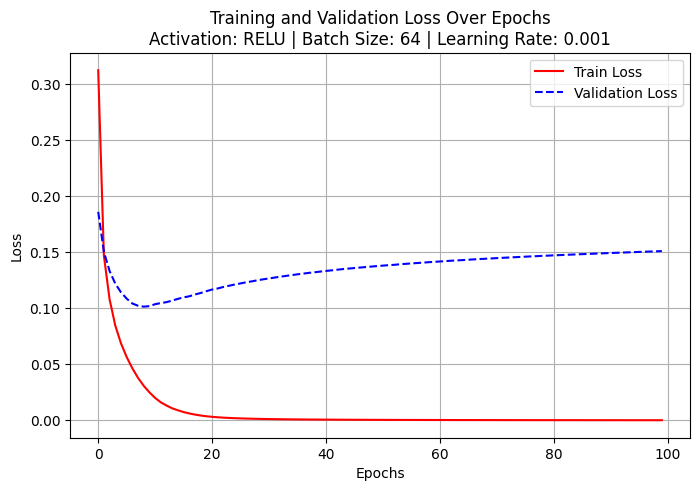

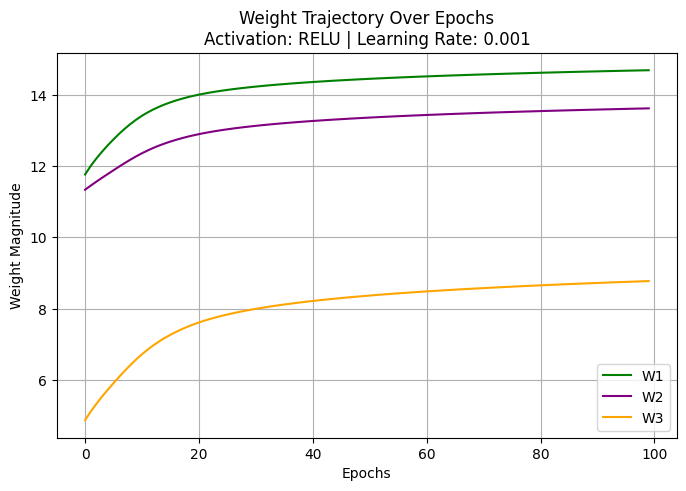

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

Wow, these results are amazing! 97.42% accuracy! This is about as good as it can get. The training loss drops to 0.002 from 0.3121 which tells me it's learning efficiently. The validation loss converges at .1509 which tells me it's generalizing well. Weight updates are stable. I doubt I will see a more perfect test than this, but we'll see.

**SIGMOID**

Let's start testing the other activation functions. I will start with Sigmoid.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 0/50, Train Loss: 0.6037, Val Loss: 0.3872
W1 329.29, W2 21.37
Epoch 10/50, Train Loss: 0.2381, Val Loss: 0.2552
W1 677.74, W2 19.75
Epoch 20/50, Train Loss: 0.1724, Val Loss: 0.2014
W1 944.63, W2 20.16
Epoch 30/50, Train Loss: 0.1480, Val Loss: 0.1886
W1 1171.39, W2 20.82
Epoch 40/50, Train Loss: 0.1445, Val Loss: 0.1871
W1 1382.93, W2 21.42
Epoch 49/50, Train Loss: 0.1426, Val Loss: 0.1924
W1 1573.48, W2 21.89
Test Accuracy: 94.37%


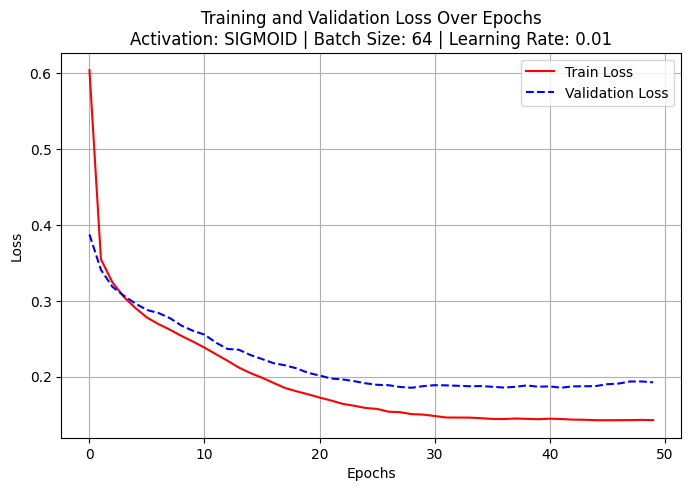

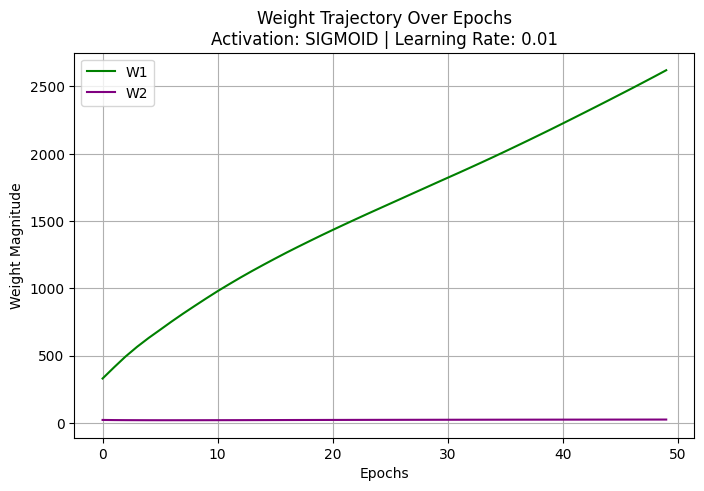

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

The logs show signs of exploding gradients. I think the learning rate needs to be lowered. Random initialization of the weights is playing a factor here also.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.7473, Val Loss: 0.5591
W1 227.89, W2 23.97
Epoch 10/50, Train Loss: 0.3457, Val Loss: 0.3866
W1 239.45, W2 21.90
Epoch 20/50, Train Loss: 0.2963, Val Loss: 0.3370
W1 249.91, W2 20.59
Epoch 30/50, Train Loss: 0.2744, Val Loss: 0.3156
W1 260.76, W2 19.68


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 40/50, Train Loss: 0.2627, Val Loss: 0.3010
W1 272.23, W2 19.04
Epoch 49/50, Train Loss: 0.2565, Val Loss: 0.2980
W1 282.85, W2 18.62
Test Accuracy: 91.73%


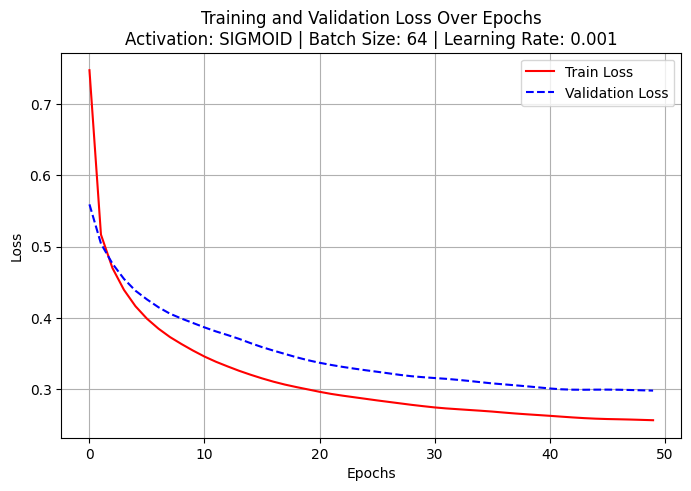

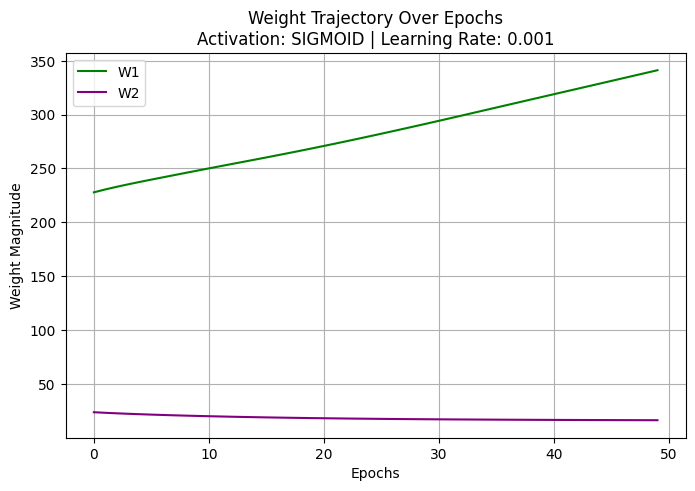

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

Decreasing the learning rate didnt really help. The accuracy is less than before but weights are still exploding. There might be some overfitting, so this accuracy doesnt mean much. Thre is still some instability with this combination of parameters.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.4049, Val Loss: 0.3265
W1 139.36, W2 9.93


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 10/50, Train Loss: 0.2600, Val Loss: 0.2760
W1 465.98, W2 12.95
Epoch 20/50, Train Loss: 0.1800, Val Loss: 0.2112
W1 751.30, W2 14.73
Epoch 30/50, Train Loss: 0.1515, Val Loss: 0.1919
W1 993.25, W2 16.15
Epoch 40/50, Train Loss: 0.1373, Val Loss: 0.1787
W1 1214.40, W2 17.27
Epoch 49/50, Train Loss: 0.1358, Val Loss: 0.1858
W1 1406.15, W2 18.11
Test Accuracy: 94.72%


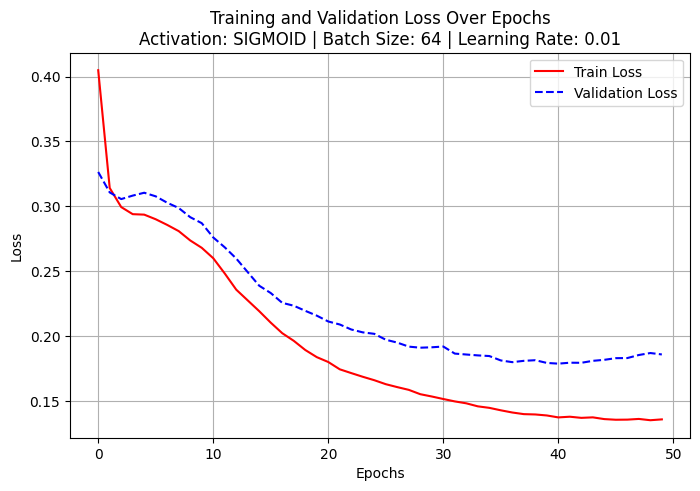

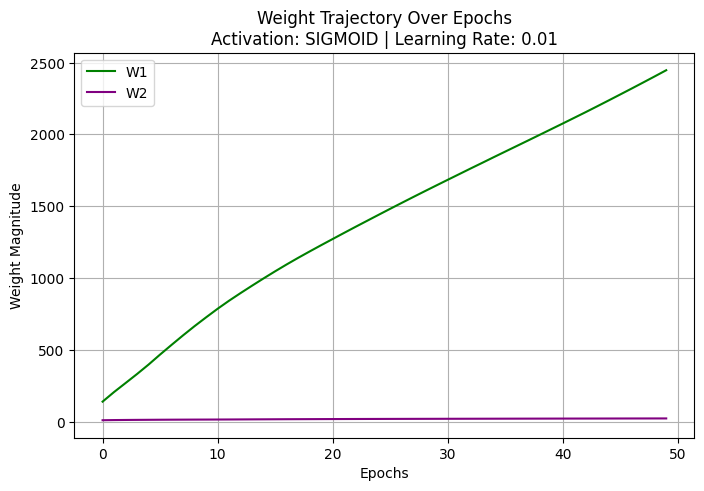

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

While accuracy is high, I think it's learning too fast. Im going to lower the learning rate and see.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.5694, Val Loss: 0.4082
W1 31.37, W2 6.46
Epoch 10/50, Train Loss: 0.2809, Val Loss: 0.3013
W1 65.14, W2 8.51
Epoch 20/50, Train Loss: 0.2638, Val Loss: 0.2952
W1 85.77, W2 9.29
Epoch 30/50, Train Loss: 0.2638, Val Loss: 0.2960
W1 103.95, W2 9.81
Epoch 40/50, Train Loss: 0.2644, Val Loss: 0.2990
W1 121.74, W2 10.21
Epoch 49/50, Train Loss: 0.2634, Val Loss: 0.2982
W1 137.80, W2 10.50
Test Accuracy: 91.96%


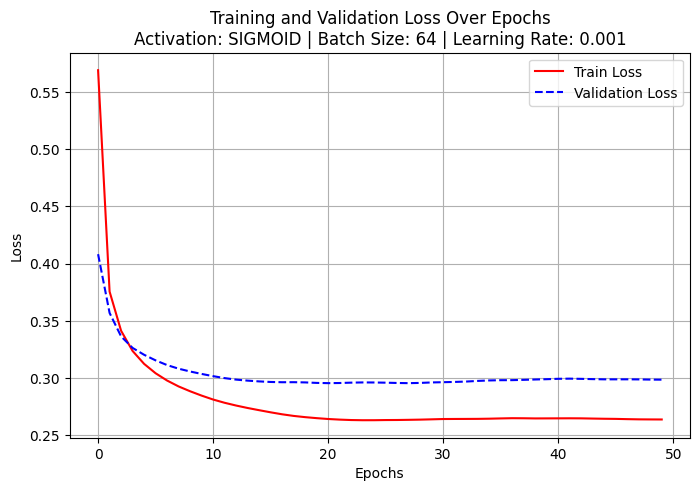

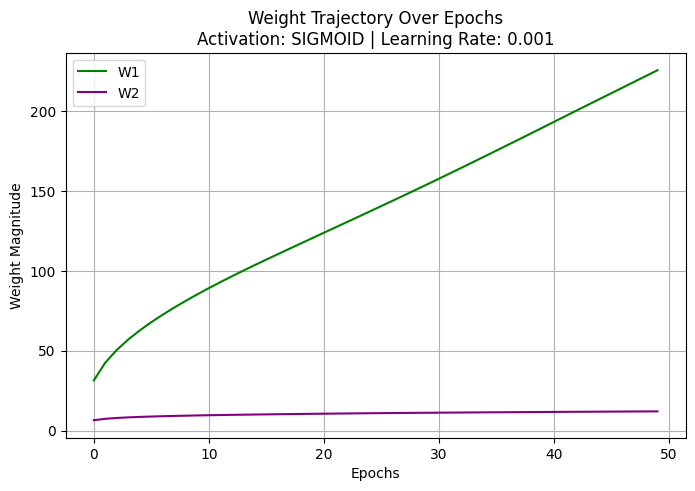

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

This looks much better. The learning is more steady with loss gradually decreasing. I am going to bump up the epochs to 100, see if I can squeeze a little more accuracy out of it.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/100, Train Loss: 0.5816, Val Loss: 0.4001
W1 32.70, W2 6.45
Epoch 10/100, Train Loss: 0.2841, Val Loss: 0.3052
W1 66.84, W2 8.57
Epoch 20/100, Train Loss: 0.2692, Val Loss: 0.2947
W1 89.49, W2 9.38
Epoch 30/100, Train Loss: 0.2614, Val Loss: 0.2918
W1 109.47, W2 9.93
Epoch 40/100, Train Loss: 0.2576, Val Loss: 0.2908
W1 128.21, W2 10.35
Epoch 50/100, Train Loss: 0.2526, Val Loss: 0.2886
W1 146.12, W2 10.69


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 60/100, Train Loss: 0.2502, Val Loss: 0.2892
W1 163.35, W2 10.97
Epoch 70/100, Train Loss: 0.2495, Val Loss: 0.2893
W1 180.10, W2 11.21
Epoch 80/100, Train Loss: 0.2483, Val Loss: 0.2884
W1 196.56, W2 11.41
Epoch 90/100, Train Loss: 0.2465, Val Loss: 0.2864
W1 212.76, W2 11.59
Epoch 99/100, Train Loss: 0.2454, Val Loss: 0.2858
W1 227.15, W2 11.72
Test Accuracy: 92.14%


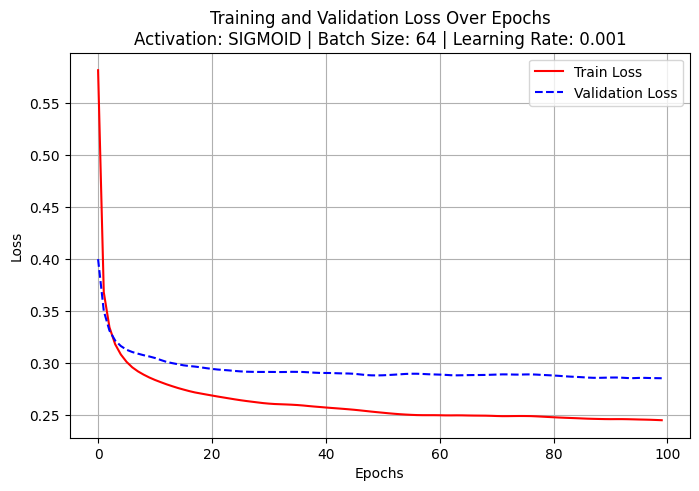

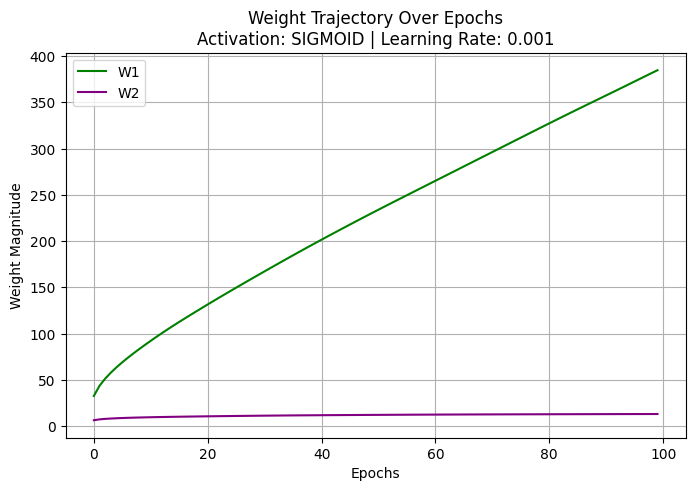

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

Ok, so this behaved as I expected. It still stabilize the learning a little better. The loss gradually decreased and the weights updated at a nice pace.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 0/50, Train Loss: 0.4793, Val Loss: 0.3268
W1 1336.23, W2 33.97
W1 1336.23, W2 33.97, W3 9.94
Epoch 10/50, Train Loss: 0.9099, Val Loss: 0.8904
W1 1173335.97, W2 466.42
W1 1173335.97, W2 466.42, W3 16.20
Epoch 20/50, Train Loss: 0.7860, Val Loss: 0.7912
W1 4107020.99, W2 884.09
W1 4107020.99, W2 884.09, W3 16.66
Epoch 30/50, Train Loss: 0.7966, Val Loss: 0.8106
W1 7026569.25, W2 1184.98
W1 7026569.25, W2 1184.98, W3 16.98
Epoch 40/50, Train Loss: 0.6963, Val Loss: 0.7099
W1 10168913.77, W2 1445.04
W1 10168913.77, W2 1445.04, W3 17.21
Epoch 49/50, Train Loss: 0.6339, Val Loss: 0.6484
W1 12823667.09, W2 1637.12
W1 12823667.09, W2 1637.12, W3 17.24
Test Accuracy: 80.32%


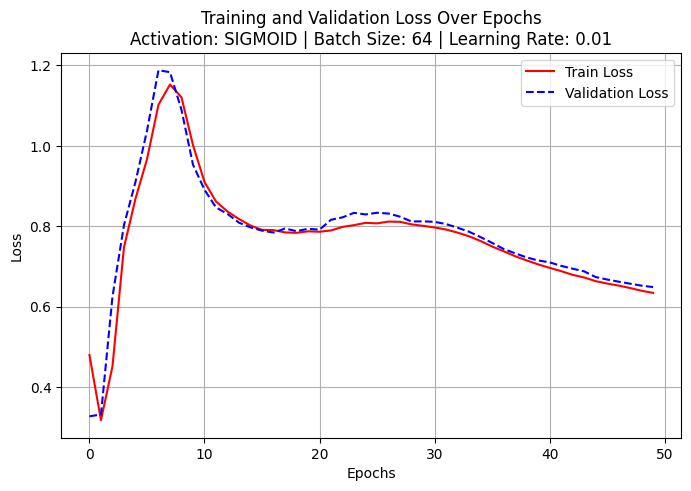

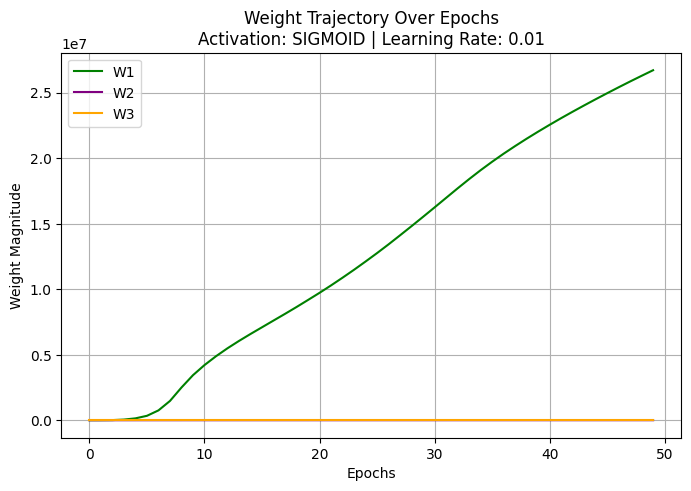

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Adding another hidden layer blew this up. Which I actually expected to happen. Im going to try lowering the learning rate. This is likely overfitting and has vanishing gradients.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.8960, Val Loss: 0.5202
W1 230.73, W2 17.70
W1 230.73, W2 17.70, W3 6.83


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 10/50, Train Loss: 0.2943, Val Loss: 0.3088
W1 624.78, W2 25.32
W1 624.78, W2 25.32, W3 8.93
Epoch 20/50, Train Loss: 0.2473, Val Loss: 0.2684
W1 925.35, W2 29.09
W1 925.35, W2 29.09, W3 9.70
Epoch 30/50, Train Loss: 0.2255, Val Loss: 0.2498
W1 1219.07, W2 32.13
W1 1219.07, W2 32.13, W3 10.23
Epoch 40/50, Train Loss: 0.2168, Val Loss: 0.2417
W1 1527.27, W2 34.78
W1 1527.27, W2 34.78, W3 10.65
Epoch 49/50, Train Loss: 0.2179, Val Loss: 0.2469
W1 1826.50, W2 36.92
W1 1826.50, W2 36.92, W3 10.96
Test Accuracy: 92.28%


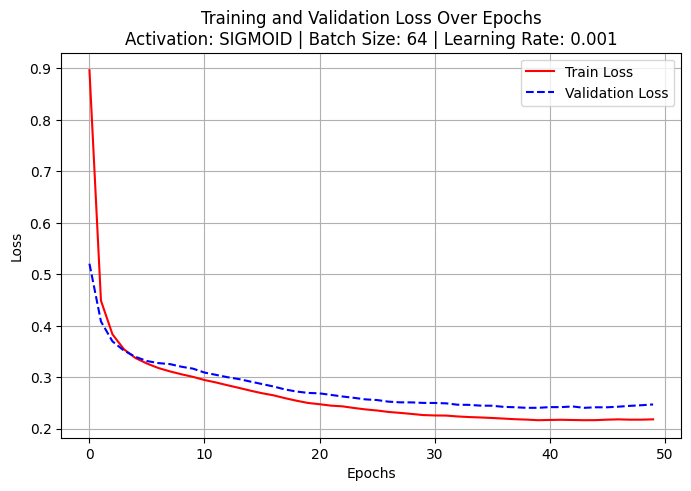

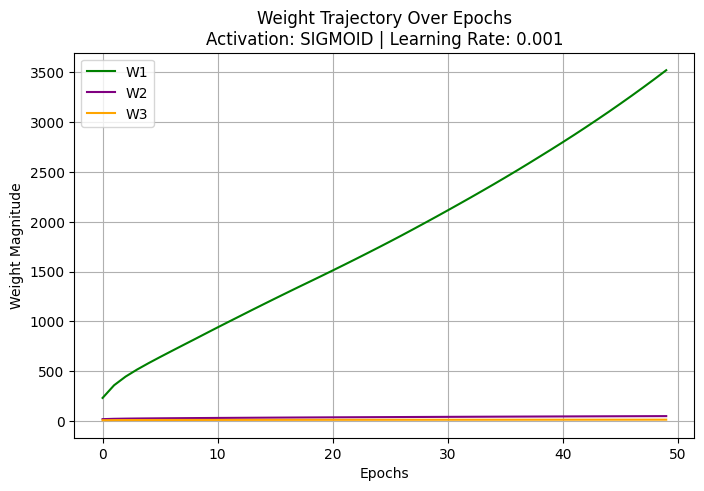

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

This did decent even with unstable weight updates, but it's still got issues like exploding gradients. Sigmoid does not handle large values well which causes instability. Im gonna try lowering the batch size.

This next test will use the following hyperparameters:

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 32

<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 0/50, Train Loss: 1.2104, Val Loss: 0.8108
W1 440.25, W2 19.32
W1 440.25, W2 19.32, W3 7.12
Epoch 10/50, Train Loss: 0.5830, Val Loss: 0.5900
W1 3857.09, W2 39.54
W1 3857.09, W2 39.54, W3 10.93
Epoch 20/50, Train Loss: 0.5803, Val Loss: 0.5952
W1 8036.01, W2 47.81
W1 8036.01, W2 47.81, W3 11.90
Epoch 30/50, Train Loss: 0.6186, Val Loss: 0.6301
W1 13014.82, W2 54.68
W1 13014.82, W2 54.68, W3 12.44
Epoch 40/50, Train Loss: 0.6496, Val Loss: 0.6641
W1 19308.69, W2 61.93
W1 19308.69, W2 61.93, W3 12.82
Epoch 49/50, Train Loss: 0.6492, Val Loss: 0.6498
W1 26290.38, W2 69.00
W1 26290.38, W2 69.00, W3 13.09
Test Accuracy: 78.83%


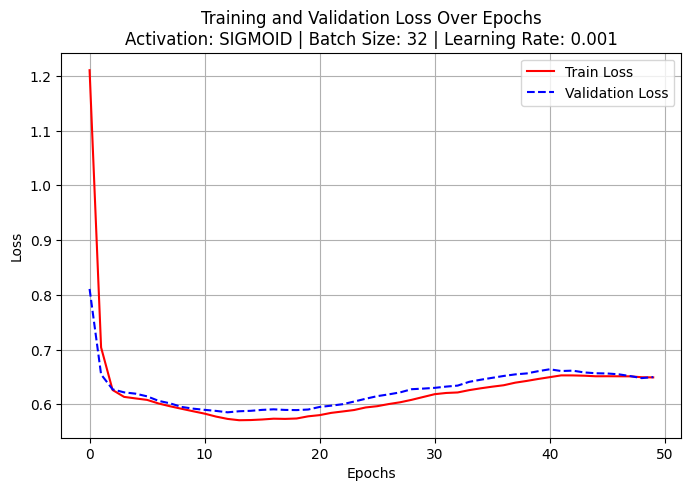

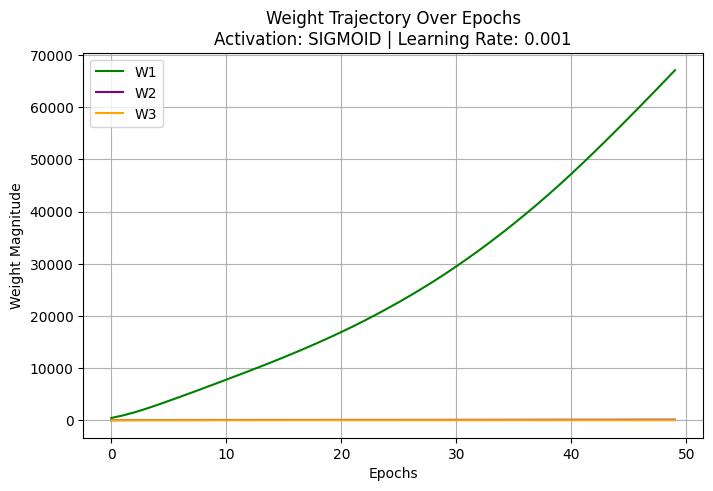

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=32, hidden_layers=2, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=32)

Decreasing the batch size did what I expected, but worse actually. I didnt expect it to perform so poorly compared to the previous test. The weight updates are out of control. This is a poor combination of parameters. I think it's time to try Tanh.

**TANH**

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.7748, Val Loss: 0.5598
W1 312.50, W2 22.73
Epoch 10/50, Train Loss: 0.4153, Val Loss: 0.4161
W1 897.30, W2 21.64
Epoch 20/50, Train Loss: 0.3414, Val Loss: 0.3556
W1 1406.83, W2 21.19
Epoch 30/50, Train Loss: 0.3295, Val Loss: 0.3582
W1 1832.86, W2 20.95
Epoch 40/50, Train Loss: 0.3122, Val Loss: 0.3472
W1 2225.62, W2 20.77
Epoch 49/50, Train Loss: 0.2942, Val Loss: 0.3304
W1 2560.42, W2 20.66
Test Accuracy: 90.05%


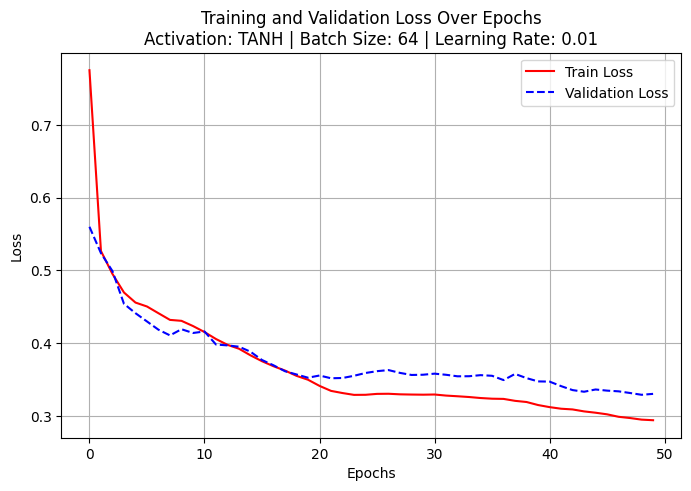

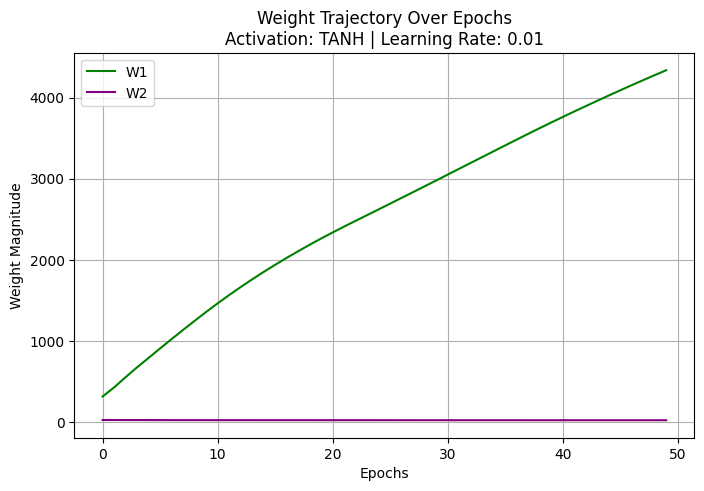

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Not a bad start for Tanh. The loss is continuely improving, so it is learning. I will increase the epochs and see if there is much improvement, I dont suspect to see much more. There is some weight instability, but tanh weight updates can be larger than sigmoid since it's centered around 0. I might also try lowering the learning rate, I think that will stabilize the weight updates.

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Random
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 1.2163, Val Loss: 0.7044
W1 233.15, W2 23.81
Epoch 10/50, Train Loss: 0.4403, Val Loss: 0.4657
W1 274.69, W2 23.33
Epoch 20/50, Train Loss: 0.4165, Val Loss: 0.4385
W1 326.93, W2 23.17
Epoch 30/50, Train Loss: 0.3983, Val Loss: 0.4218
W1 384.07, W2 23.03
Epoch 40/50, Train Loss: 0.3751, Val Loss: 0.4043
W1 442.09, W2 22.89
Epoch 49/50, Train Loss: 0.3687, Val Loss: 0.3949
W1 493.61, W2 22.78
Test Accuracy: 88.48%


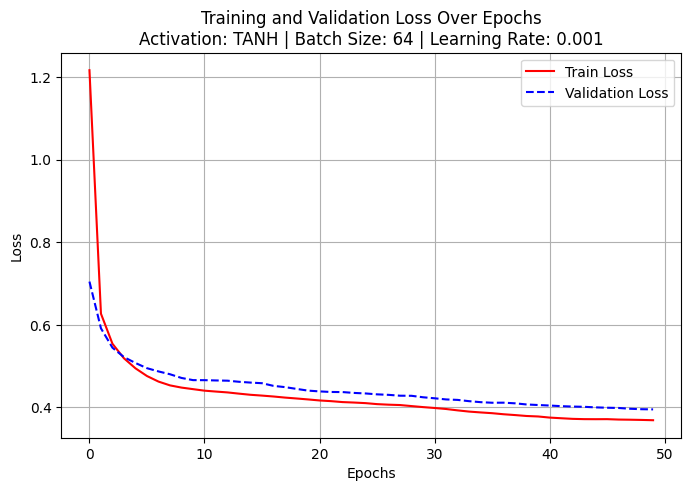

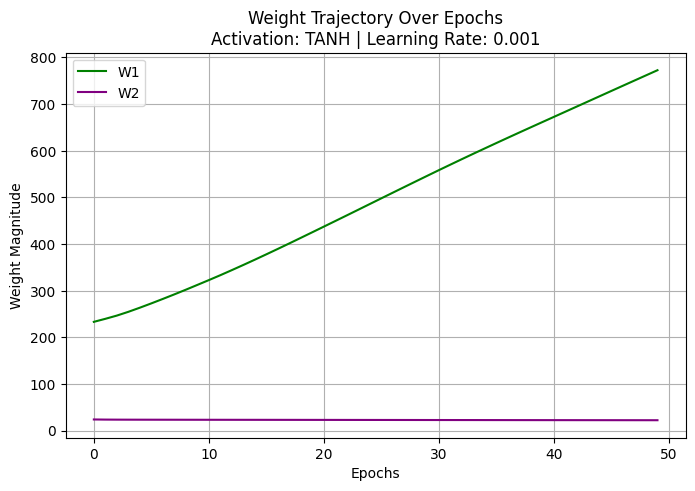

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="random")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

Weight updates are less extreme which seem to show signs of a more stable model. Loss is improving, so this model is learning well.

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.5835, Val Loss: 0.4049
W1 124.32, W2 8.19
Epoch 10/50, Train Loss: 0.2377, Val Loss: 0.2627
W1 403.60, W2 10.79
Epoch 20/50, Train Loss: 0.2297, Val Loss: 0.2650
W1 645.38, W2 11.74
Epoch 30/50, Train Loss: 0.2297, Val Loss: 0.2695
W1 885.92, W2 12.31
Epoch 40/50, Train Loss: 0.2284, Val Loss: 0.2660
W1 1127.01, W2 12.71
Epoch 49/50, Train Loss: 0.2289, Val Loss: 0.2657
W1 1341.79, W2 12.96
Test Accuracy: 91.83%


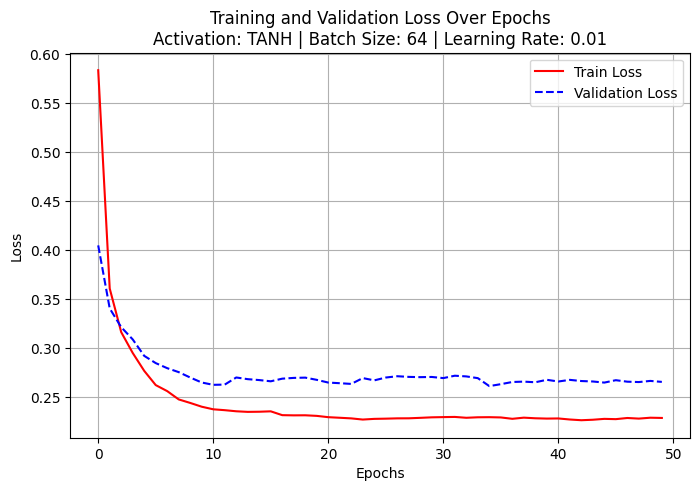

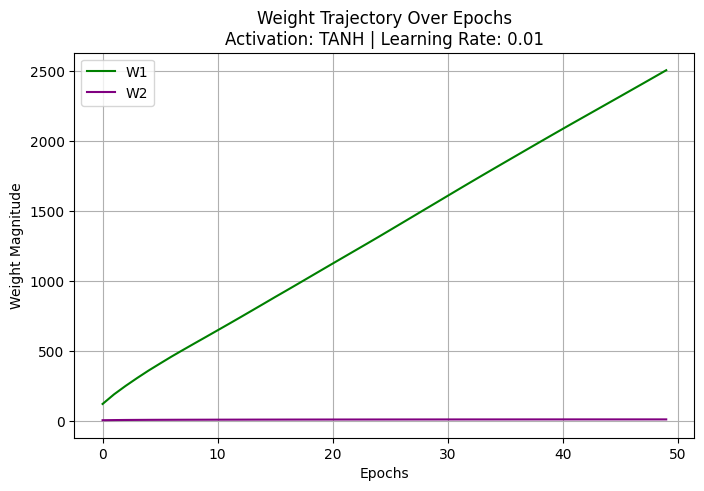

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

This configuration of parameters is what I expected when using Xavier weight initialization and Tanh, which pair together nicely. The loss is very stable. This model generalizes well despite W1's extreme growth. I suppose this isnt suprising since tanh can cause large gradients. Im going to lower the learning rate, see if it stabilizes more.

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.001
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.6853, Val Loss: 0.5218
W1 29.43, W2 5.51
Epoch 10/50, Train Loss: 0.3731, Val Loss: 0.3867
W1 70.78, W2 6.52
Epoch 20/50, Train Loss: 0.3586, Val Loss: 0.3728
W1 106.62, W2 6.93
Epoch 30/50, Train Loss: 0.3381, Val Loss: 0.3545
W1 139.59, W2 7.14
Epoch 40/50, Train Loss: 0.3374, Val Loss: 0.3593
W1 170.93, W2 7.32
Epoch 49/50, Train Loss: 0.3378, Val Loss: 0.3570
W1 198.95, W2 7.47
Test Accuracy: 89.92%


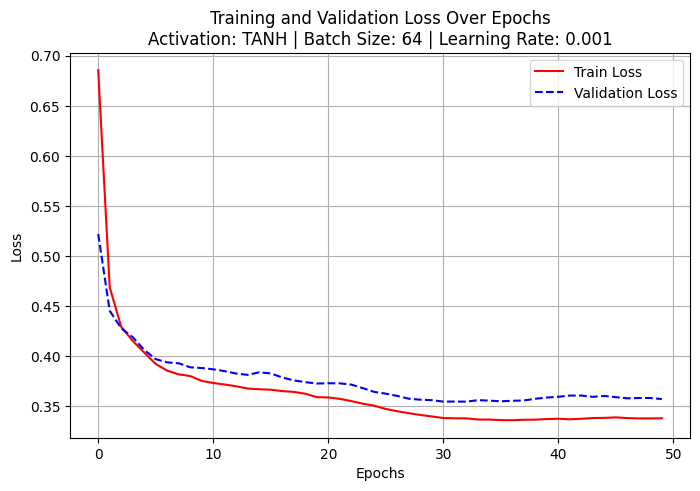

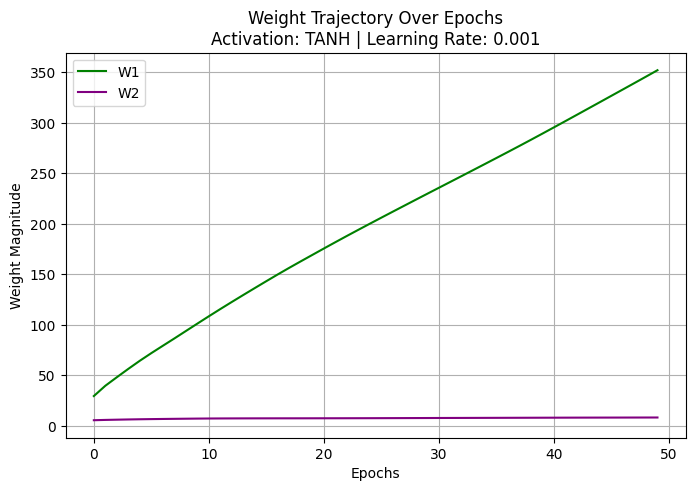

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

Epoch 0/100, Train Loss: 0.7264, Val Loss: 0.5624
W1 34.14, W2 5.75
Epoch 10/100, Train Loss: 0.3544, Val Loss: 0.3601
W1 75.31, W2 6.34
Epoch 20/100, Train Loss: 0.3253, Val Loss: 0.3296
W1 105.23, W2 6.68
Epoch 30/100, Train Loss: 0.3172, Val Loss: 0.3309
W1 133.36, W2 6.96
Epoch 40/100, Train Loss: 0.3122, Val Loss: 0.3272
W1 160.83, W2 7.16
Epoch 50/100, Train Loss: 0.3102, Val Loss: 0.3272
W1 188.29, W2 7.35
Epoch 60/100, Train Loss: 0.3146, Val Loss: 0.3296
W1 216.03, W2 7.53
Epoch 70/100, Train Loss: 0.3214, Val Loss: 0.3359
W1 244.24, W2 7.69
Epoch 80/100, Train Loss: 0.3245, Val Loss: 0.3383
W1 273.17, W2 7.83
Epoch 90/100, Train Loss: 0.3248, Val Loss: 0.3406
W1 302.76, W2 7.95
Epoch 99/100, Train Loss: 0.3235, Val Loss: 0.3434
W1 329.83, W2 8.04
Test Accuracy: 90.19%


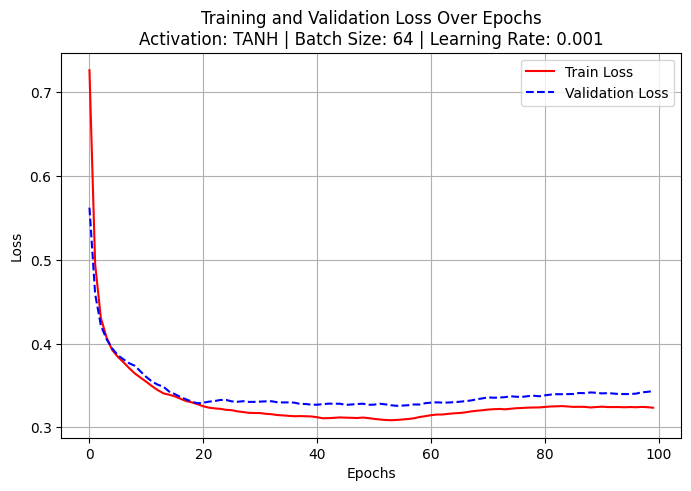

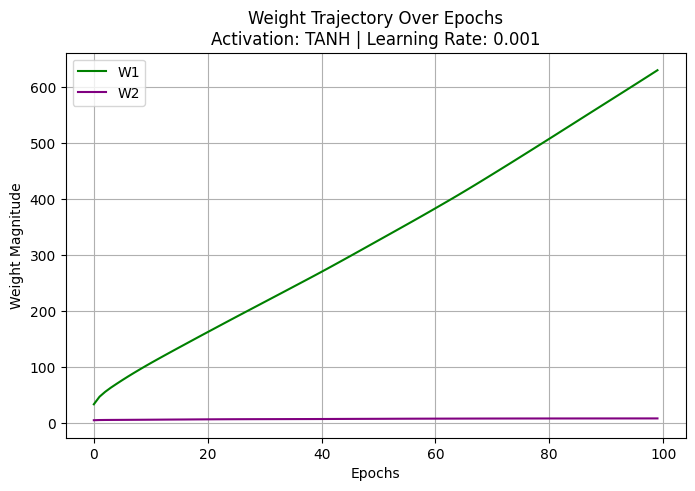

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

Increasing the epochs did help imporve learning, but not by much. I think this is as accurate as it will get with this configuration.

My prediction for this next test, I will be adding another layer, and it is going to do poorly. It's goin to do poorly because by adding another layer, it has a better chance of vanishing gradients with tanh. The model might suffer from overfitting too.

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.6620, Val Loss: 0.5161
W1 439.02, W2 23.04
W1 439.02, W2 23.04, W3 8.07
Epoch 10/50, Train Loss: 0.8183, Val Loss: 0.8114
W1 4245.23, W2 61.29
W1 4245.23, W2 61.29, W3 12.06
Epoch 20/50, Train Loss: 0.9277, Val Loss: 0.7810
W1 11811.09, W2 99.12
W1 11811.09, W2 99.12, W3 13.72
Epoch 30/50, Train Loss: 0.9130, Val Loss: 0.8132
W1 22966.00, W2 135.17
W1 22966.00, W2 135.17, W3 14.59
Epoch 40/50, Train Loss: 0.9315, Val Loss: 0.7708
W1 38031.85, W2 171.31
W1 38031.85, W2 171.31, W3 15.09
Epoch 49/50, Train Loss: 0.8607, Val Loss: 0.7710
W1 55685.25, W2 204.47
W1 55685.25, W2 204.47, W3 15.40
Test Accuracy: 77.24%


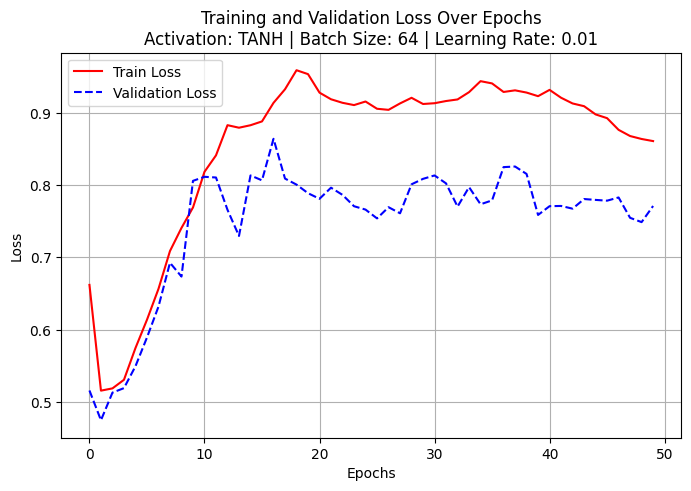

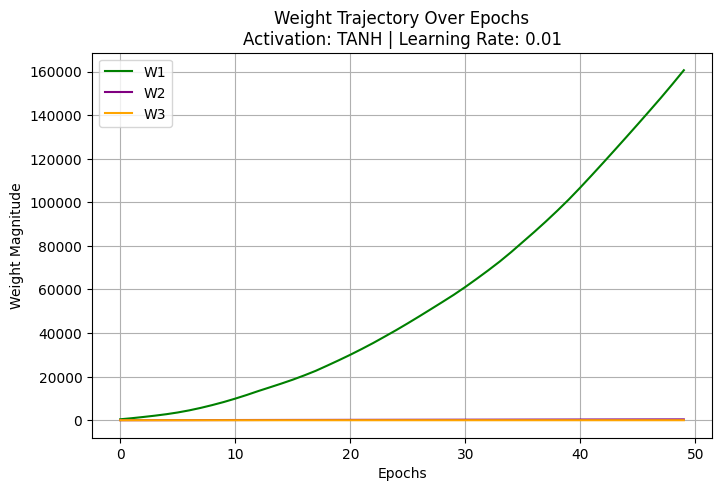

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

As expected, this did very poorly in comparison. The weights are not stable and not adjusting well. W1 is growing exponentially. Loss is all over the place, growing then shrinking.

Epoch 0/50, Train Loss: 0.9832, Val Loss: 0.7225
W1 112.16, W2 11.81
W1 112.16, W2 11.81, W3 5.41
Epoch 10/50, Train Loss: 0.4699, Val Loss: 0.4686
W1 318.55, W2 15.40
W1 318.55, W2 15.40, W3 5.94
Epoch 20/50, Train Loss: 0.4296, Val Loss: 0.4290
W1 564.89, W2 19.48
W1 564.89, W2 19.48, W3 6.54
Epoch 30/50, Train Loss: 0.3917, Val Loss: 0.4076
W1 837.34, W2 23.18
W1 837.34, W2 23.18, W3 6.96
Epoch 40/50, Train Loss: 0.3838, Val Loss: 0.3995
W1 1104.59, W2 26.38
W1 1104.59, W2 26.38, W3 7.32
Epoch 49/50, Train Loss: 0.3721, Val Loss: 0.3932
W1 1353.26, W2 29.06
W1 1353.26, W2 29.06, W3 7.62
Test Accuracy: 88.33%


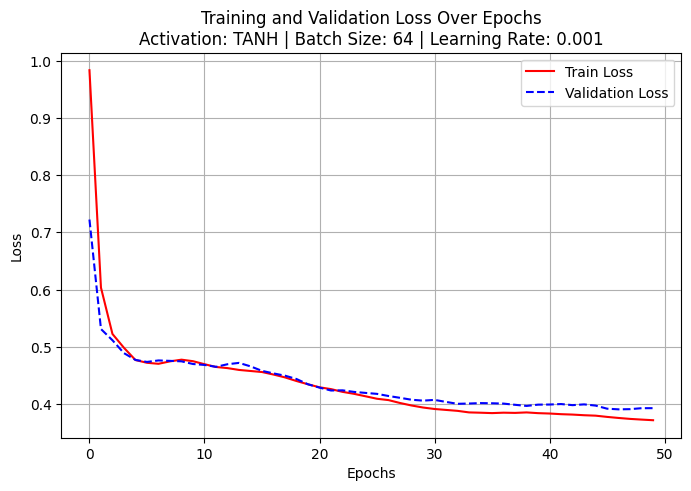

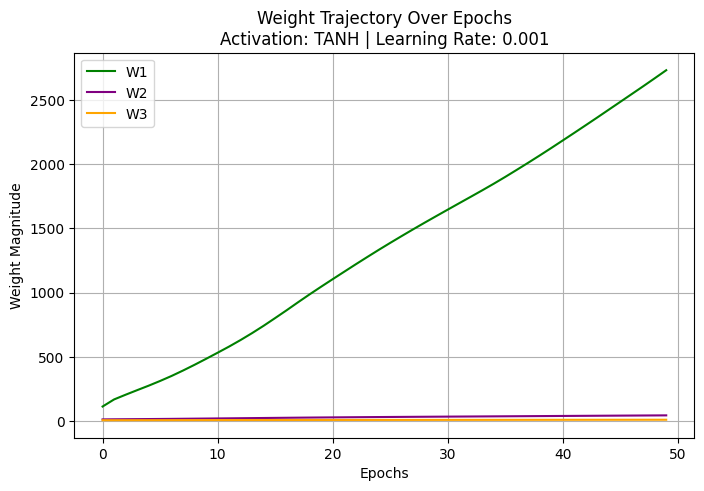

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=50, batch_size=64)

By lowering the learning rate, the model has stabilized a great deal. The loss is improving and the weights arent updating wildly, but slowly and methodically. I might be able to acheive a little more accuracy by increasing the epochs to allow it to train a little longer.

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: Xavier
* Hidden Layers: 2
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/100, Train Loss: 0.9668, Val Loss: 0.7136
W1 108.77, W2 11.66
W1 108.77, W2 11.66, W3 5.43
Epoch 10/100, Train Loss: 0.4478, Val Loss: 0.4496
W1 274.13, W2 14.74
W1 274.13, W2 14.74, W3 5.94
Epoch 20/100, Train Loss: 0.4412, Val Loss: 0.4504
W1 473.77, W2 18.24
W1 473.77, W2 18.24, W3 6.51
Epoch 30/100, Train Loss: 0.4209, Val Loss: 0.4387
W1 713.43, W2 21.64
W1 713.43, W2 21.64, W3 6.99
Epoch 40/100, Train Loss: 0.3984, Val Loss: 0.4074
W1 971.66, W2 24.79
W1 971.66, W2 24.79, W3 7.39
Epoch 50/100, Train Loss: 0.3775, Val Loss: 0.3954
W1 1232.30, W2 27.64
W1 1232.30, W2 27.64, W3 7.75
Epoch 60/100, Train Loss: 0.3676, Val Loss: 0.3887
W1 1487.65, W2 30.23
W1 1487.65, W2 30.23, W3 8.06
Epoch 70/100, Train Loss: 0.3657, Val Loss: 0.3836
W1 1742.26, W2 32.64
W1 1742.26, W2 32.64, W3 8.35
Epoch 80/100, Train Loss: 0.3700, Val Loss: 0.3917
W1 2005.12, W2 34.97
W1 2005.12, W2 34.97, W3 8.61
Epoch 90/100, Train Loss: 0.3774, Val Loss: 0.3952
W1 2284.35, W2 37.26
W1 2284.35, W2 37.26,

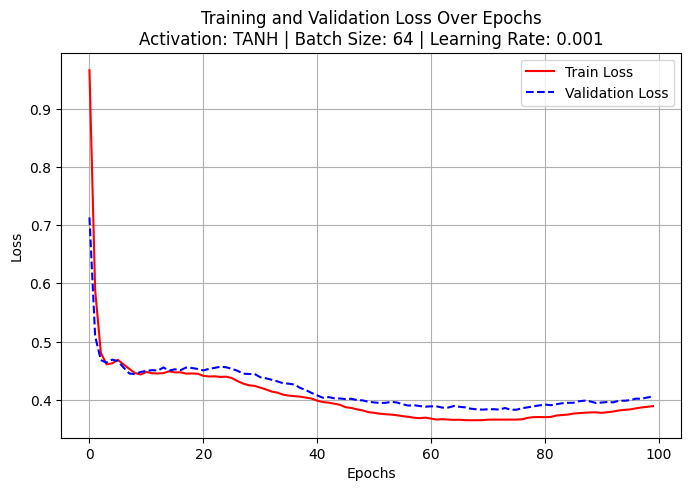

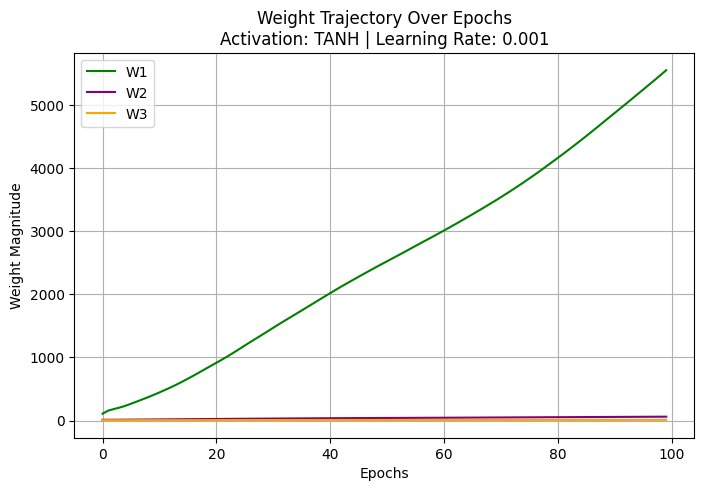

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=2, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

This next test will use the following hyperparameters:

* Activation Function: Tanh
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

Epoch 0/50, Train Loss: 0.6198, Val Loss: 0.4092
W1 136.26, W2 8.34
Epoch 10/50, Train Loss: 0.2586, Val Loss: 0.2913
W1 438.71, W2 10.42
Epoch 20/50, Train Loss: 0.2375, Val Loss: 0.2838
W1 686.69, W2 11.40
Epoch 30/50, Train Loss: 0.2304, Val Loss: 0.2859
W1 920.32, W2 12.08
Epoch 40/50, Train Loss: 0.2228, Val Loss: 0.2808
W1 1147.66, W2 12.58
Epoch 49/50, Train Loss: 0.2188, Val Loss: 0.2774
W1 1347.08, W2 12.93
Test Accuracy: 91.98%


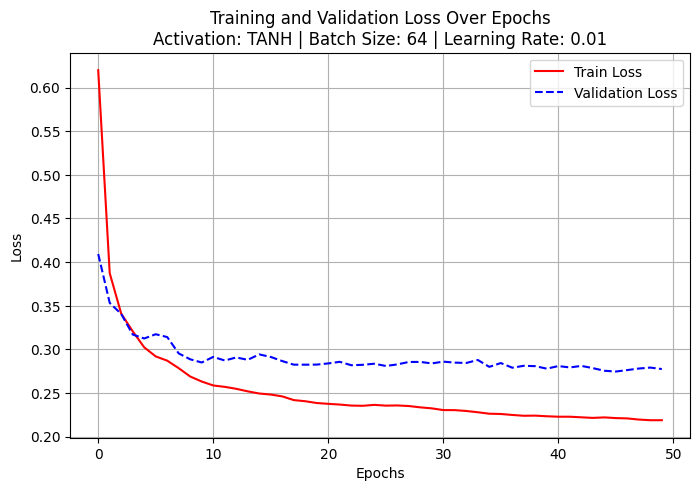

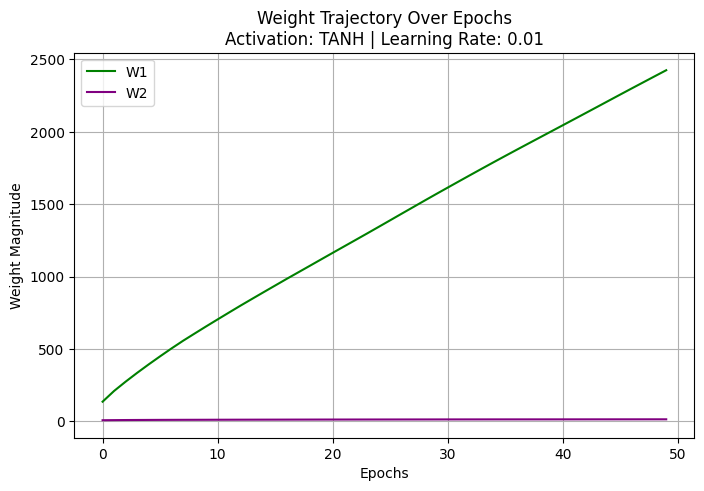

In [ ]:
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Im actually surprised this combo of tanh an He did so well, since He works best with Relu and not so much with sigmoid/tanh. It achieved a decent accuracy, low loss and the weight updates werent too out of control, except W1, but it still wasnt all that bad. I think it is overfitting though regardless of the accuracy.

Im going to run this next test with all the same parameters for each function, but using their bes weight initializations.

This next test will use the following hyperparameters:

* Activation Function: ReLU
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64
--------------------------------

* Activation Function: Tanh
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64
---------------------------------

* Activation Function: Sigmoid
* Learning Rate: 0.01
* Epochs: 50
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

This is RELU
Epoch 0/50, Train Loss: 0.7897, Val Loss: 0.4756
W1 23.95, W2 12.83
Epoch 10/50, Train Loss: 0.2239, Val Loss: 0.3244
W1 32.13, W2 13.32
Epoch 20/50, Train Loss: 0.1691, Val Loss: 0.3799
W1 37.31, W2 13.78
Epoch 30/50, Train Loss: 0.1485, Val Loss: 0.3782
W1 41.92, W2 14.24
Epoch 40/50, Train Loss: 0.1390, Val Loss: 0.4439
W1 46.18, W2 14.73
Epoch 49/50, Train Loss: 0.1367, Val Loss: 0.4374
W1 49.80, W2 15.15
Test Accuracy: 94.32%


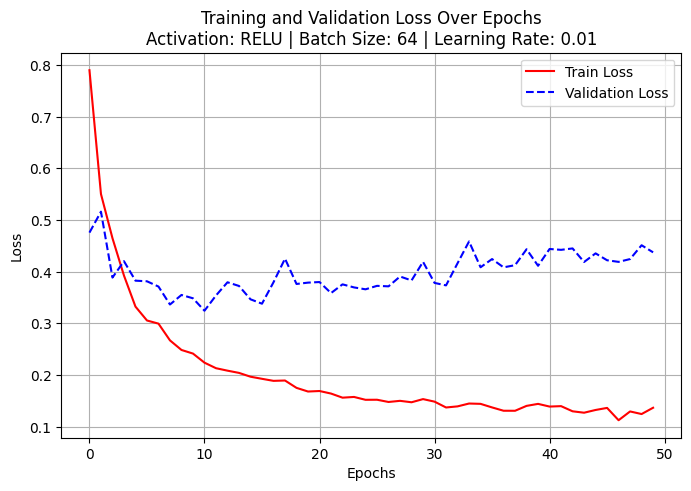

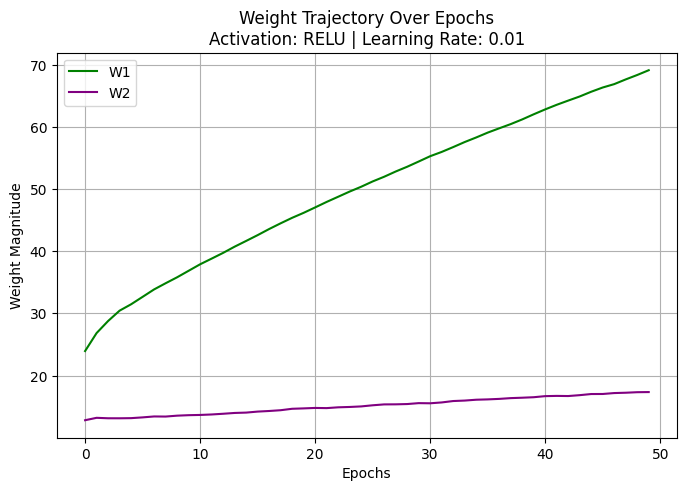

This is Sigmoid
Epoch 0/50, Train Loss: 0.4142, Val Loss: 0.3353
W1 152.21, W2 9.87


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 10/50, Train Loss: 0.2457, Val Loss: 0.2584
W1 483.47, W2 12.88
Epoch 20/50, Train Loss: 0.1749, Val Loss: 0.1990
W1 767.03, W2 14.84
Epoch 30/50, Train Loss: 0.1490, Val Loss: 0.1925
W1 1012.64, W2 16.42
Epoch 40/50, Train Loss: 0.1499, Val Loss: 0.1943
W1 1242.85, W2 17.57
Epoch 49/50, Train Loss: 0.1467, Val Loss: 0.1995
W1 1452.33, W2 18.36
Test Accuracy: 94.08%


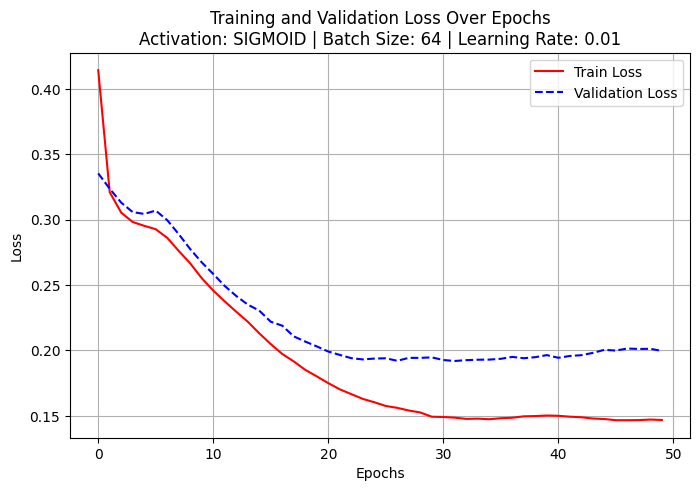

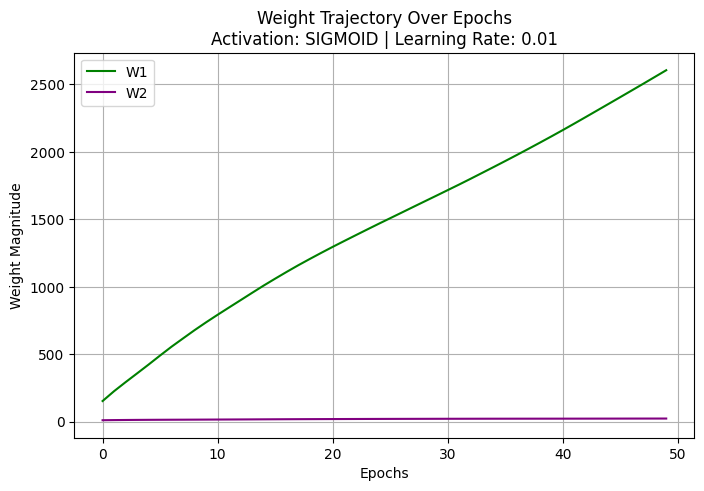

This is Tanh
Epoch 0/50, Train Loss: 0.5155, Val Loss: 0.3778
W1 101.69, W2 8.10
Epoch 10/50, Train Loss: 0.2259, Val Loss: 0.2592
W1 362.38, W2 10.93
Epoch 20/50, Train Loss: 0.2007, Val Loss: 0.2553
W1 578.34, W2 12.01
Epoch 30/50, Train Loss: 0.1908, Val Loss: 0.2472
W1 777.11, W2 12.67
Epoch 40/50, Train Loss: 0.1823, Val Loss: 0.2429
W1 967.13, W2 13.17
Epoch 49/50, Train Loss: 0.1794, Val Loss: 0.2330
W1 1132.66, W2 13.53
Test Accuracy: 93.22%


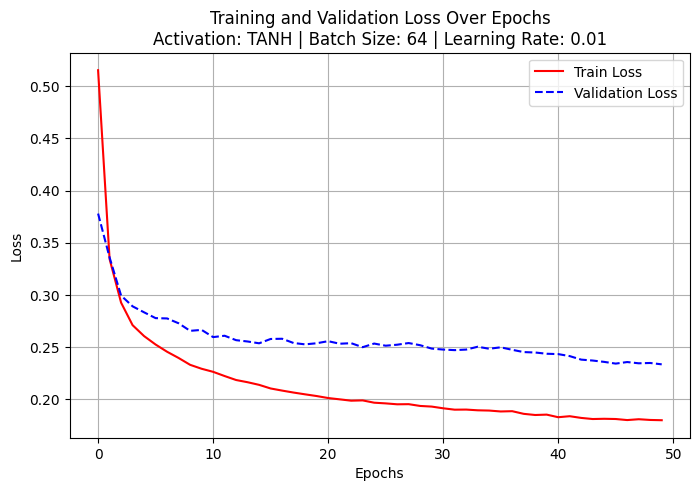

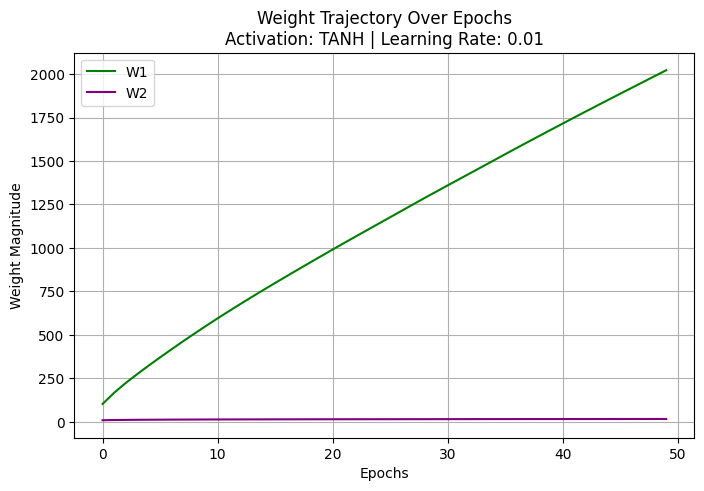

In [ ]:
print("This is RELU")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)
print("This is Sigmoid")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)
print("This is Tanh")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.01, epochs=50, batch_size=64)

Observations:

- Relu performed the best, this is not surprising. Relu had the lowest training loss, though validation was a little high, which might indicate slight overfitting. It had stable growth and small increases in weight updates. I believe this would do well for deeper networks.

- Sigmoid had better generalization than Relu. The accuracy was close to Relu's as well, but with the exploding weight updates, I suspect that accuracy is not the truth, I believe there is some overfitting going on. This model is unstable.

- Tanh was the most balanced of the 3. It had the best generalization and it's accuracy wasnt that much less than the other 2. Weight growth was small overall, indicating some stability, more than sigmoid. I believe this still suffered from vanishing gradients.

This next test will use the following hyperparameters:

* Activation Function: ReLU
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: He
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64
--------------------------------

* Activation Function: Tanh
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64
--------------------------------

* Activation Function: Sigmoid
* Learning Rate: 0.001
* Epochs: 100
* Weight Initialization: Xavier
* Hidden Layers: 1
* Neurons per Layer: 64
* Batch Size: 64

This is RELU
Epoch 0/100, Train Loss: 0.3166, Val Loss: 0.2046
W1 11.84, W2 4.91
Epoch 10/100, Train Loss: 0.0365, Val Loss: 0.1096
W1 12.90, W2 6.37
Epoch 20/100, Train Loss: 0.0116, Val Loss: 0.1132
W1 13.59, W2 7.30
Epoch 30/100, Train Loss: 0.0050, Val Loss: 0.1214
W1 14.09, W2 7.98
Epoch 40/100, Train Loss: 0.0028, Val Loss: 0.1280
W1 14.45, W2 8.49
Epoch 50/100, Train Loss: 0.0019, Val Loss: 0.1328
W1 14.72, W2 8.88
Epoch 60/100, Train Loss: 0.0014, Val Loss: 0.1364
W1 14.95, W2 9.19
Epoch 70/100, Train Loss: 0.0011, Val Loss: 0.1393
W1 15.13, W2 9.45
Epoch 80/100, Train Loss: 0.0009, Val Loss: 0.1419
W1 15.28, W2 9.68
Epoch 90/100, Train Loss: 0.0008, Val Loss: 0.1441
W1 15.42, W2 9.87
Epoch 99/100, Train Loss: 0.0007, Val Loss: 0.1460
W1 15.53, W2 10.02
Test Accuracy: 97.42%


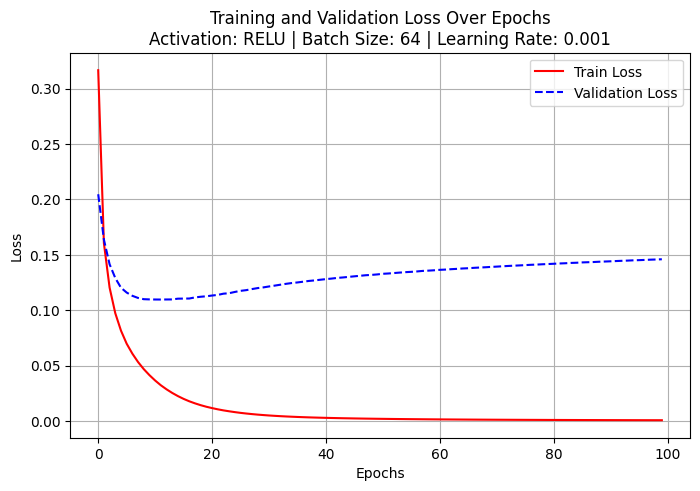

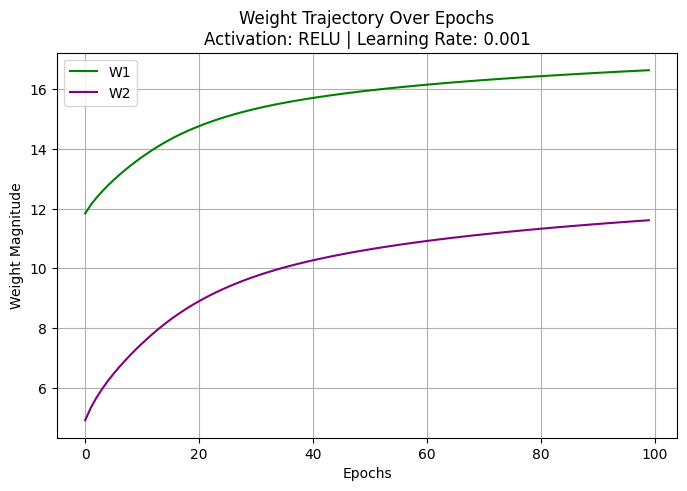

This is Sigmoid
Epoch 0/100, Train Loss: 0.5711, Val Loss: 0.4010
W1 32.00, W2 6.45
Epoch 10/100, Train Loss: 0.2767, Val Loss: 0.2939
W1 63.61, W2 8.54
Epoch 20/100, Train Loss: 0.2622, Val Loss: 0.2881
W1 83.49, W2 9.35
Epoch 30/100, Train Loss: 0.2590, Val Loss: 0.2882
W1 101.45, W2 9.90
Epoch 40/100, Train Loss: 0.2586, Val Loss: 0.2901
W1 118.81, W2 10.31
Epoch 50/100, Train Loss: 0.2552, Val Loss: 0.2896
W1 135.90, W2 10.63


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 60/100, Train Loss: 0.2500, Val Loss: 0.2861
W1 152.66, W2 10.89
Epoch 70/100, Train Loss: 0.2484, Val Loss: 0.2818
W1 169.04, W2 11.12
Epoch 80/100, Train Loss: 0.2460, Val Loss: 0.2813
W1 185.10, W2 11.33
Epoch 90/100, Train Loss: 0.2456, Val Loss: 0.2836
W1 200.87, W2 11.51
Epoch 99/100, Train Loss: 0.2453, Val Loss: 0.2826
W1 214.91, W2 11.66
Test Accuracy: 92.43%


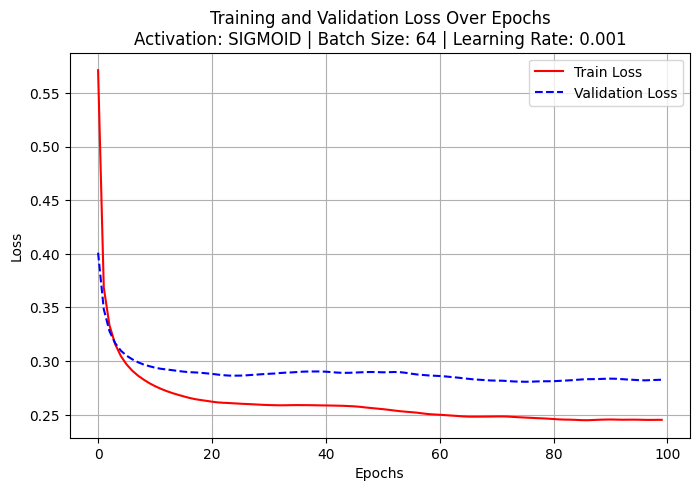

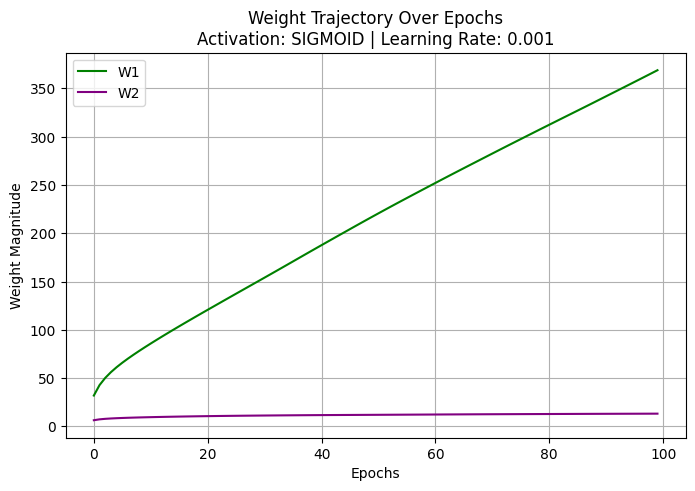

This is Tanh
Epoch 0/100, Train Loss: 0.7239, Val Loss: 0.5495
W1 32.78, W2 5.58
Epoch 10/100, Train Loss: 0.3744, Val Loss: 0.3872
W1 79.07, W2 6.52
Epoch 20/100, Train Loss: 0.3475, Val Loss: 0.3668
W1 115.33, W2 6.93
Epoch 30/100, Train Loss: 0.3335, Val Loss: 0.3635
W1 147.98, W2 7.20
Epoch 40/100, Train Loss: 0.3254, Val Loss: 0.3558
W1 178.81, W2 7.43
Epoch 50/100, Train Loss: 0.3221, Val Loss: 0.3522
W1 208.95, W2 7.64
Epoch 60/100, Train Loss: 0.3211, Val Loss: 0.3545
W1 239.23, W2 7.82
Epoch 70/100, Train Loss: 0.3260, Val Loss: 0.3572
W1 270.07, W2 7.98
Epoch 80/100, Train Loss: 0.3295, Val Loss: 0.3575
W1 301.71, W2 8.13
Epoch 90/100, Train Loss: 0.3312, Val Loss: 0.3499
W1 334.17, W2 8.25
Epoch 99/100, Train Loss: 0.3332, Val Loss: 0.3529
W1 363.97, W2 8.34
Test Accuracy: 89.67%


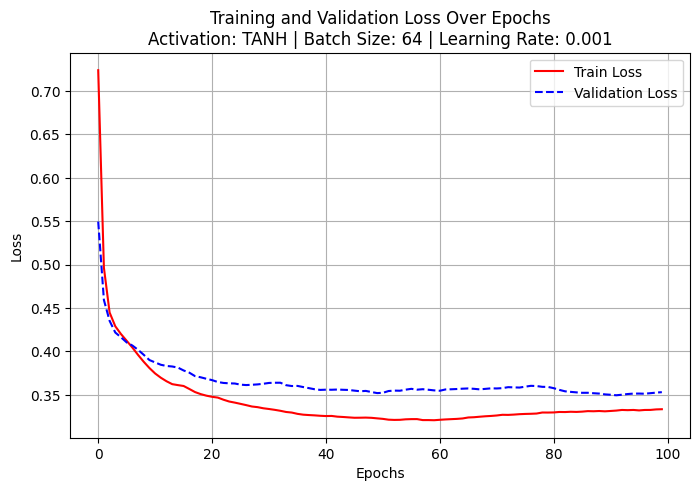

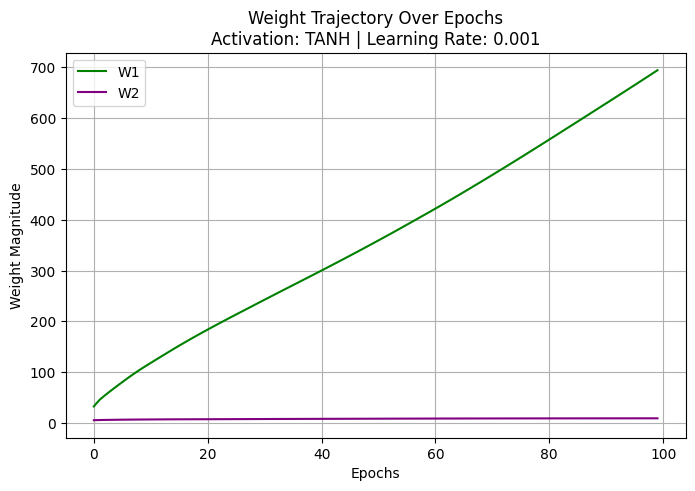

In [ ]:
print("This is RELU")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)
print("This is Sigmoid")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)
print("This is Tanh")
nn = Neural_Network(input_size=784, hidden_size=64, hidden_layers=1, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

Observations

- Relu performed outstanding here, again acheiving the best it will probably get. The lowest training loss and validation loss indicating strong generalization. Weight updates were moderate to low, indicating nice stable growth. The learning rate here really makes this model shine. I would say this is great for fast training and deep networks.

- Sigmoid is just generally unstable. Im not sure if this is due to my implementation or the nature of sigmoid. Based on research about sigmoid, this seems to be right on par with expectations. Unstable, I wouldnt use this model but for simple and small networks.

- Tanh had slower training than the other 2. Both training loss and validation loss weren't that good, but weight adjustments were mostly stable, they didnt grow wildly. I would say this is only good for shallow networks.

This is RELU
Epoch 0/100, Train Loss: 0.2903, Val Loss: 0.1648
W1 16.31, W2 16.17
W1 16.31, W2 16.17, W3 5.02
Epoch 10/100, Train Loss: 0.0087, Val Loss: 0.0986
W1 16.98, W2 16.61
W1 16.98, W2 16.61, W3 6.16
Epoch 20/100, Train Loss: 0.0016, Val Loss: 0.1036
W1 17.28, W2 16.86
W1 17.28, W2 16.86, W3 6.75
Epoch 30/100, Train Loss: 0.0008, Val Loss: 0.1082
W1 17.45, W2 17.00
W1 17.45, W2 17.00, W3 7.09
Epoch 40/100, Train Loss: 0.0005, Val Loss: 0.1119
W1 17.56, W2 17.10
W1 17.56, W2 17.10, W3 7.31
Epoch 50/100, Train Loss: 0.0004, Val Loss: 0.1149
W1 17.63, W2 17.17
W1 17.63, W2 17.17, W3 7.47
Epoch 60/100, Train Loss: 0.0003, Val Loss: 0.1174
W1 17.70, W2 17.23
W1 17.70, W2 17.23, W3 7.60
Epoch 70/100, Train Loss: 0.0002, Val Loss: 0.1194
W1 17.75, W2 17.28
W1 17.75, W2 17.28, W3 7.71
Epoch 80/100, Train Loss: 0.0002, Val Loss: 0.1212
W1 17.79, W2 17.31
W1 17.79, W2 17.31, W3 7.80
Epoch 90/100, Train Loss: 0.0002, Val Loss: 0.1227
W1 17.82, W2 17.35
W1 17.82, W2 17.35, W3 7.87
Epoch 99

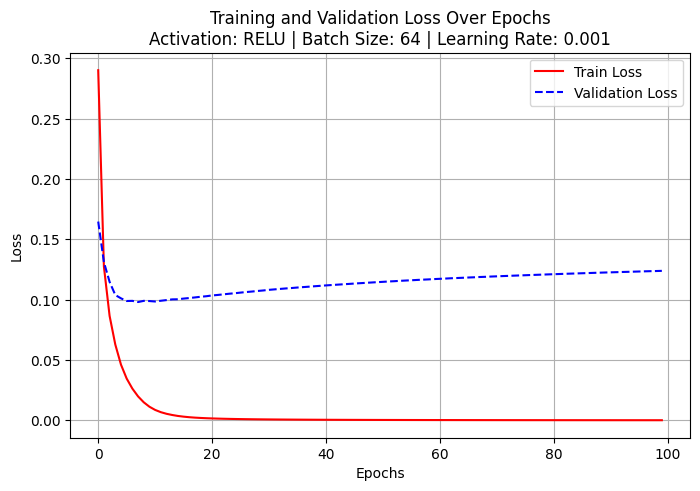

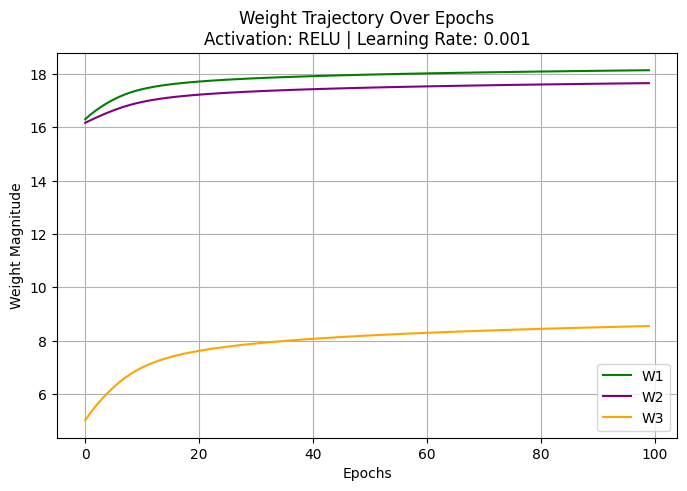

This is Sigmoid
Epoch 0/100, Train Loss: 0.6858, Val Loss: 0.4016
W1 115.34, W2 17.52
W1 115.34, W2 17.52, W3 6.33


<ipython-input-3-2be7bbc11ca0>:35: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


Epoch 10/100, Train Loss: 0.2668, Val Loss: 0.2929
W1 280.71, W2 22.69
W1 280.71, W2 22.69, W3 8.10
Epoch 20/100, Train Loss: 0.2416, Val Loss: 0.2773
W1 409.15, W2 25.31
W1 409.15, W2 25.31, W3 8.85
Epoch 30/100, Train Loss: 0.2294, Val Loss: 0.2649
W1 524.18, W2 27.32
W1 524.18, W2 27.32, W3 9.40
Epoch 40/100, Train Loss: 0.1991, Val Loss: 0.2348
W1 640.52, W2 29.12
W1 640.52, W2 29.12, W3 9.87
Epoch 50/100, Train Loss: 0.1734, Val Loss: 0.2149
W1 764.00, W2 30.84
W1 764.00, W2 30.84, W3 10.28
Epoch 60/100, Train Loss: 0.1523, Val Loss: 0.1968
W1 895.51, W2 32.43
W1 895.51, W2 32.43, W3 10.65
Epoch 70/100, Train Loss: 0.1346, Val Loss: 0.1876
W1 1032.57, W2 33.90
W1 1032.57, W2 33.90, W3 10.99
Epoch 80/100, Train Loss: 0.1210, Val Loss: 0.1804
W1 1172.26, W2 35.26
W1 1172.26, W2 35.26, W3 11.29
Epoch 90/100, Train Loss: 0.1109, Val Loss: 0.1773
W1 1313.32, W2 36.55
W1 1313.32, W2 36.55, W3 11.57
Epoch 99/100, Train Loss: 0.1045, Val Loss: 0.1769
W1 1441.21, W2 37.66
W1 1441.21, W2 37

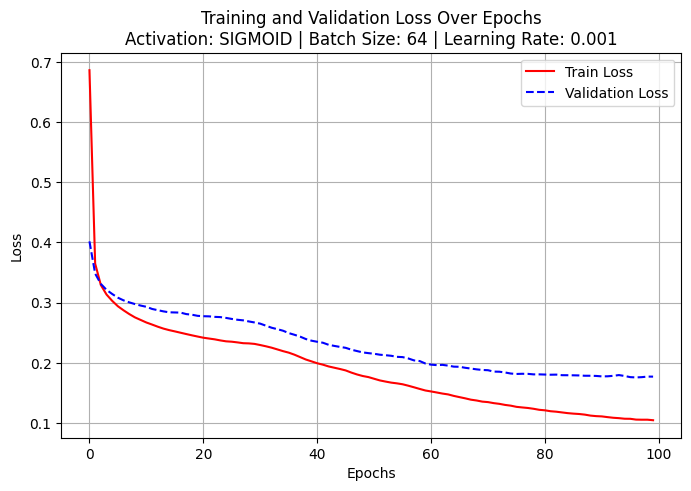

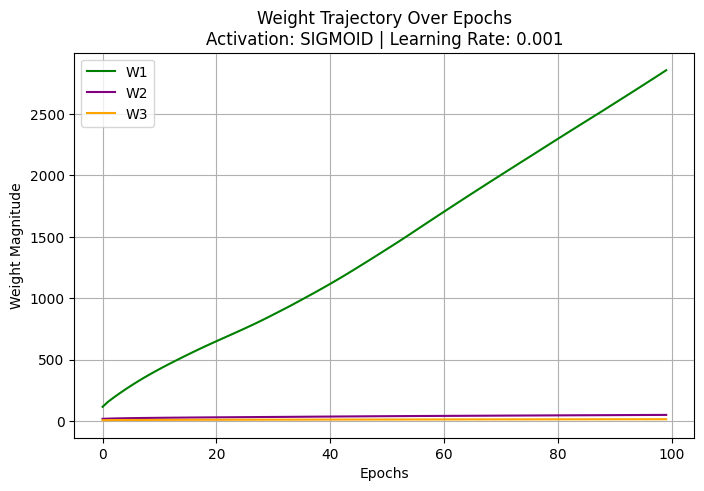

This is Tanh
Epoch 0/100, Train Loss: 0.6805, Val Loss: 0.4527
W1 43.78, W2 12.91
W1 43.78, W2 12.91, W3 5.09
Epoch 10/100, Train Loss: 0.3472, Val Loss: 0.3510
W1 141.56, W2 16.16
W1 141.56, W2 16.16, W3 6.01
Epoch 20/100, Train Loss: 0.2876, Val Loss: 0.3097
W1 245.43, W2 19.46
W1 245.43, W2 19.46, W3 6.72
Epoch 30/100, Train Loss: 0.2774, Val Loss: 0.3003
W1 353.52, W2 22.48
W1 353.52, W2 22.48, W3 7.30
Epoch 40/100, Train Loss: 0.2504, Val Loss: 0.2863
W1 468.31, W2 25.24
W1 468.31, W2 25.24, W3 7.77
Epoch 50/100, Train Loss: 0.2355, Val Loss: 0.2725
W1 582.74, W2 27.69
W1 582.74, W2 27.69, W3 8.17
Epoch 60/100, Train Loss: 0.2241, Val Loss: 0.2707
W1 695.47, W2 29.90
W1 695.47, W2 29.90, W3 8.54
Epoch 70/100, Train Loss: 0.2179, Val Loss: 0.2630
W1 806.47, W2 31.94
W1 806.47, W2 31.94, W3 8.88
Epoch 80/100, Train Loss: 0.2084, Val Loss: 0.2578
W1 916.87, W2 33.83
W1 916.87, W2 33.83, W3 9.19
Epoch 90/100, Train Loss: 0.2035, Val Loss: 0.2560
W1 1026.55, W2 35.60
W1 1026.55, W2 35.

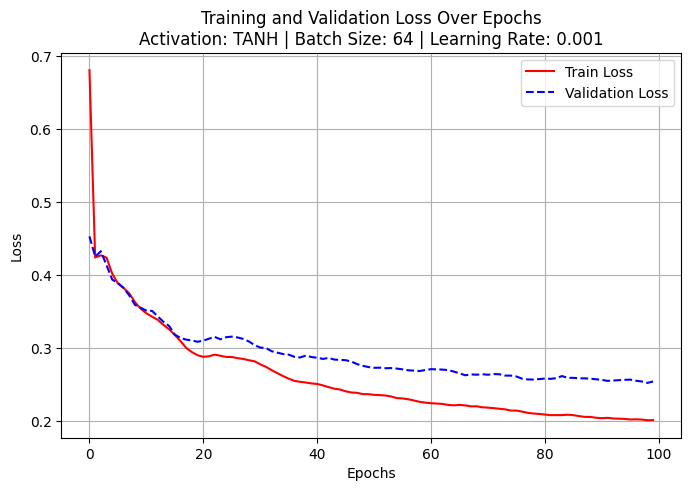

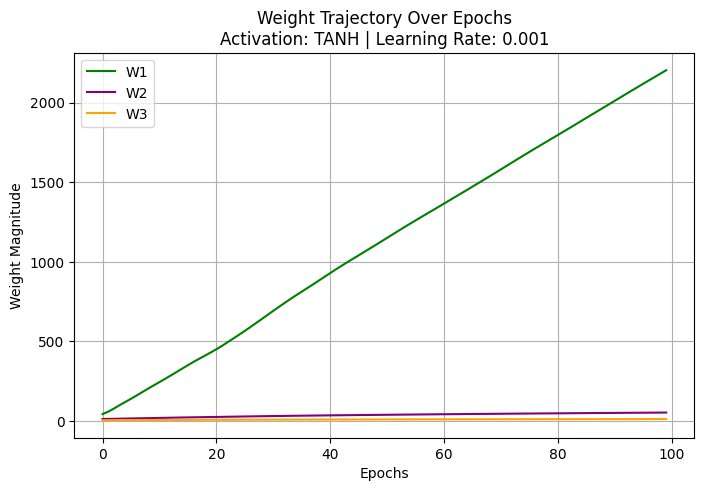

In [ ]:
print("This is RELU")
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=2, output_size=10, activation="relu", weight_init="he")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)
print("This is Sigmoid")
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=2, output_size=10, activation="sigmoid", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)
print("This is Tanh")
nn = Neural_Network(input_size=784, hidden_size=128, hidden_layers=2, output_size=10, activation="tanh", weight_init="xavier")
nn.train(x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=100, batch_size=64)

Observations

- Relu performed even better than it peviously did, 97.94%! That's incredible, now I wonder if I can tweak it to acheive 98-99%. Relu seems to be the best of the 3 for deep learning and fast training. Extremely low loss, high accuracy, stable weight adjustments. This is a stable and efficient model.

- Sigmoid performed well again, but still has some flaws. It may be suffering from saturation, causing the gradients to shrink and prevent weight updates. The slow convergence tells me it's not suitable for deep networks.

- Tanh didnt do well compared to the other 2. But it does seem to have 2 of its weights updating nice and stable, while one seems a little unstable. Generalization here is worse than with sigmoid.

DESIGN CHOICES and CODE REFERENCES

The inspiration for my design choices for this neural network was based on what I have learned so far in class, with the coding examples we've worked on and the github repo shared for class. It was also based on doing research on the topic, such as the Xavier and He weight initializations. I originally coded the softmax method for use in my network, based on an article that nicely explained it and had code samples. It worked but I kept running into some mathematical errors that I just couldnt get to work correctly. Even after some AI tooling help, it made it worse, so I opted to use the built in implementation of it instead.

NOTES: I fixed the logic for printing epochs and weights after all testing was completed and didnt have time to re-run all tests unfortunately. And now after having watched lecture 2, I realize I could have introduced some more parameters to eliminate the exploding gradients, such as leaky relu, some optimizers suchs as gradeint clipping to keep those large gradients down.


REFERENCES

Inspiration for Categorical cross entropy

https://neuralthreads.medium.com/categorical-cross-entropy-loss-the-most-important-loss-function-d3792151d05b

Inspiration for various methods

https://github.com/NVDLI/LDL/blob/main/stand_alone/c4e2_2level_learning_mnist.ipynb

For inspiration of He and Xavier initialization

https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
https://www.deeplearning.ai/ai-notes/initialization/index.html
https://paperswithcode.com/method/he-initialization
https://stackoverflow.com/questions/62249084/what-is-the-numpy-equivalent-of-tensorflow-xavier-initializer-for-cnn
https://github.com/rvarun7777/Deep_Learning/blob/master/Improving%20Deep%20Neural%20Networks_Hyperparameter%20tuning_%20Regularization/Week%201/Initialization.py

For help plotting graphs

https://www.w3schools.com/python/matplotlib_grid.asp
https://matplotlib.org/stable/index.html

